## Missingness Diagnostics & Imputation Planning

This notebook **investigates the patterns and causes of missing data among the variables** that passed the consistency and harmonization checks. Rather than immediately applying statistical imputation, it first examines whether missing values can be logically explained by the relationships between variables.

The analysis follows a two-stage approach: 

**1. Descriptive Diagnostics**

Missingness is explored using descriptive diagnostics to identify which variables and survey months exhibit notable levels of missing data.

**2. Logical and Contextual Assessment**

Logical and contextual relationships between variables are assessed to determine whether missing entries are meaningful, expected, or structurally driven. For example, **missing values in one variable may be reasonable given the recorded value of another variable**, indicating that the absence of data is not random but conditional.

This approach helps distinguish between different types of missingness: **(1) logically implied or structurally valid missing values** and **(2) unexplained missingness that may require statistical treatment**. By prioritizing logical interpretation before imputation, the notebook ensures that **statistical methods are applied only when appropriate and that the original meaning of the survey data is preserved**.

##### Objectives
- Provide a deep understanding of missing data behavior across the survey months.
- Guide informed decisions on whether to apply Deterministic Recoding **(Logic-based)** or Statistical Imputation **(Probability-based)**.
- Preserve the original meaning and intent of the survey design.

##### Output:
- `CLEANED Logic-Corrected Surveys`: Stores the refined survey files where missing data were resolved through logic-based rules
- `NEW FMI Report (Post-Logic-Based Imputation)`: Contains the new FMI report of the variables after applying logic-based imputation.

This notebook provides an understanding of missing data behavior and guides informed decisions about whether and how imputation should be performed.

---
### Missingness Overview of Consistent Variables

This section provides an overview of data presence across the consistent variables. By loading the **Fraction of Missing Information (FMI)** profile, we can see the total percentage of missing data for each variable throughout the survey months.

It is critical to note that a high missingness percentage (High FMI) does not automatically result in a variable being dropped as this missingness could be structurally driven. For example, variables related to "Hours Worked" will naturally show high missingness among respondents who are *Unemployed* or *Not in the Labor Force*. **Instead of discarding these variables, we perform a logical assessment to determine if these missingness are actually meaningful zeros or structural skips that can be resolved through logic-based recoding.**

FILE LOADED: fmi_profile_consistent.csv
TOTAL CONSISTENT VARIABLES: 20


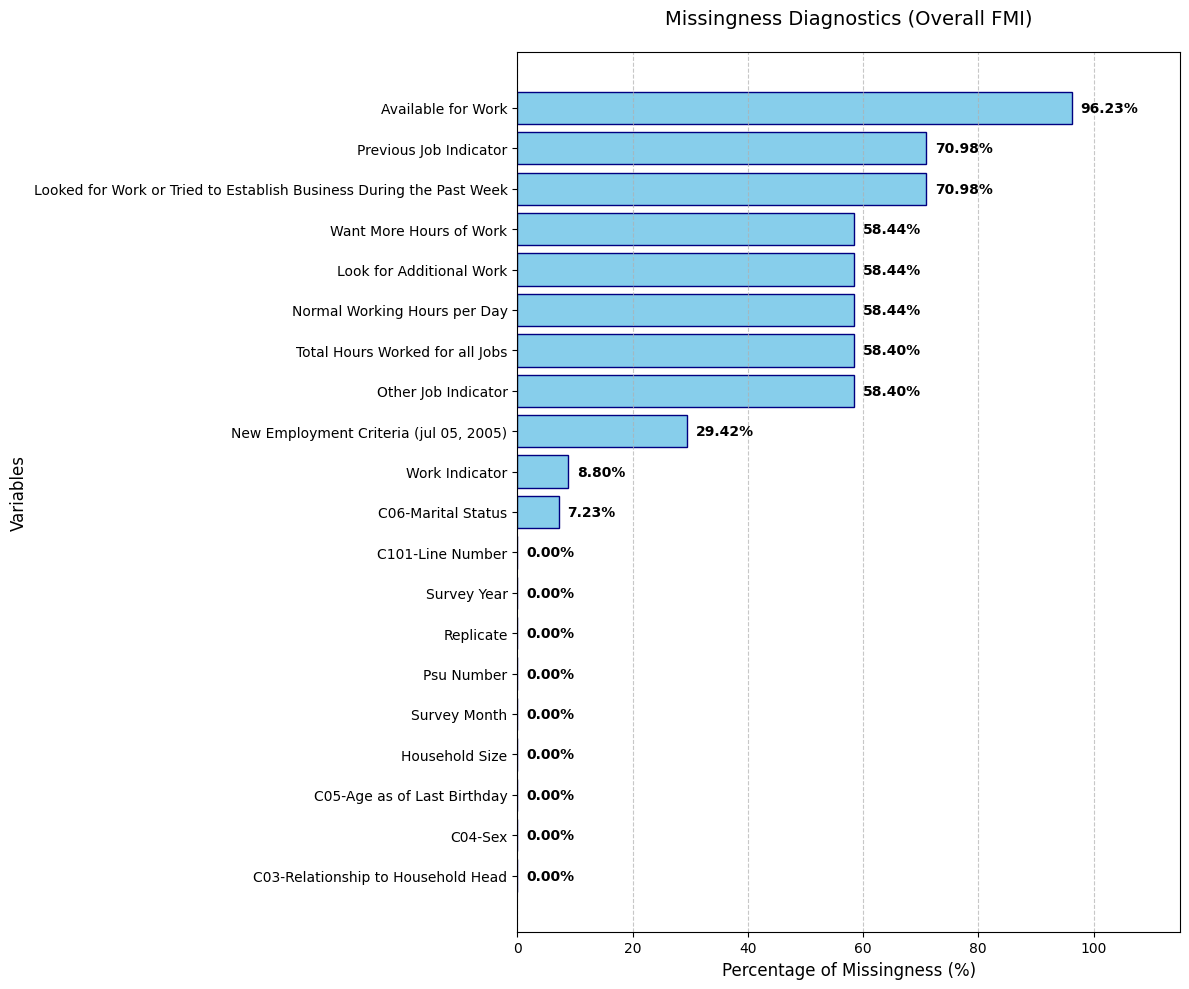

,Variable,ConsistencyTag,TotalMissing,TotalRows,AvgFMI,MonthsObserved,OverallFMI,Flag,Recommendation
0,Available for Work,consistent,5761109,5986548,0.966259,40,0.962342,Critical,Validate/Drop
8,Looked for Work or Tried to Establish Business...,consistent,4249287,5986548,0.721832,40,0.709806,Critical,Validate/Drop
12,Previous Job Indicator,consistent,4249287,5986548,0.721832,40,0.709806,Critical,Validate/Drop
10,Normal Working Hours per Day,consistent,3498660,5986548,0.569600,40,0.584420,Critical,Validate/Drop
18,Want More Hours of Work,consistent,3498660,5986548,0.569600,40,0.584420,Critical,Validate/Drop
7,Look for Additional Work,consistent,3498660,5986548,0.569600,40,0.584420,Critical,Validate/Drop
11,Other Job Indicator,consistent,3496057,5986548,0.569239,40,0.583985,Critical,Validate/Drop
17,Total Hours Worked for all Jobs,consistent,3496057,5986548,0.569239,40,0.583985,Critical,Validate/Drop
9,"New Employment Criteria (jul 05, 2005)",consistent,1761399,5986548,0.291432,40,0.294226,High,Structural Skip - Logical Imputation
19,Work Indicator,consistent,527075,5986548,0.087308,40,0.088043,Moderate,Impute/Keep


In [1]:
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

# 1. Load config
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
MONTH_ORDER = cfg["MONTH_ORDER"]

# --- PATH DEFINITIONS ---
SOURCE_ROOT = BASE_PATH / "FINAL Consistent Surveys"
FMI_ROOT = BASE_PATH / "NEW FMI Reports"
CONSISTENT_FMI_PATH = FMI_ROOT / "fmi_profile_consistent.csv"

# 2. Load the Consistent Variables list and Visualize
try:
    fmi_consistent_df = pd.read_csv(CONSISTENT_FMI_PATH)
    consistent_vars = fmi_consistent_df['Variable'].tolist()
    
    print("="*60)
    print(f"FILE LOADED: {CONSISTENT_FMI_PATH.name}")
    print(f"TOTAL CONSISTENT VARIABLES: {len(consistent_vars)}")
    print("="*60)
    
    # Sort for better visualization (highest missingness at the top)
    plot_df = fmi_consistent_df.sort_values(by='OverallFMI', ascending=True)
    
    # --- VISUALIZATION: MISSINGNESS PERCENTAGE ---
    # Increased height (12) to prevent vertical overlapping of variable names
    plt.figure(figsize=(12, 10)) 
    
    # Create horizontal bar chart
    # Multiply FMI by 100 to show as a percentage
    missing_pct = plot_df['OverallFMI'] * 100
    bars = plt.barh(plot_df['Variable'], missing_pct, color='skyblue', edgecolor='navy')
    
    # Formatting
    plt.xlabel('Percentage of Missingness (%)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Missingness Diagnostics (Overall FMI)', fontsize=14, pad=20)
    
    # --- ADJUSTMENT: Padding for labels ---
    # We set the limit to 115% to ensure the text labels on the right don't clip
    max_val = missing_pct.max()
    plt.xlim(0, max_val + 15 if max_val < 85 else 115) 
    
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add percentage labels on the bars for clarity
    for bar in bars:
        width = bar.get_width()
        # Add a small offset so text doesn't touch the bar
        plt.text(width + 1.5, bar.get_y() + bar.get_height()/2, 
                 f'{width:.2f}%', va='center', fontsize=10, fontweight='bold')

    # tight_layout(rect=...) can help if you still see clipping on the edges
    plt.tight_layout() 
    plt.show()

    # Preview the Macro-Summary table
    display(fmi_consistent_df.sort_values(by='OverallFMI', ascending=False))
    
except Exception as e:
    print(f"[ERROR] Could not load consistent variable list or generate plot: {e}")

#### Categorical Value Reference Dictionary

This section generates a reference dictionary of unique category values for each categorical variable included in the consistent variable set. Numeric and temporal variables are excluded to focus only on variables with meaningful labels.

For each categorical variable, the notebook extracts and consolidates unique response categories across survey years. The resulting dictionary is used as a guide for logical missingness assessment, helping interpret whether missing values are reasonable given the structure and meaning of each variable.

In [2]:
import pandas as pd
from pathlib import Path

# --- GLOBAL CONSTANTS ---
# Adding the missing definition to handle various "empty" string representations
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

# --- CONFIGURATION FROM USER ---
TEMPORAL_VARS = ["Survey Month", "Survey Year"]
NUMERIC_ACTUAL_VARS = [
    "C101-Line Number", "Normal Working Hours per Day", "Psu Number", 
    "Replicate", 
    "Household Size", "Total Hours Worked for all Jobs"
]

# Combined skip list
SKIP_METADATA = set(TEMPORAL_VARS + NUMERIC_ACTUAL_VARS)

def run_metadata_audit_v2(base_path, vars_list):
    metadata_map = {}
    year_folders = sorted([d for d in base_path.iterdir() if d.is_dir()])

    print(" AUDITING CATEGORICAL METADATA (Skipping Numeric/Temporal)...")
    
    for year_folder in year_folders:
        try:
            # Check one file per year to capture potential code changes
            sample_file = next(year_folder.glob("*.csv"))
            
            # Determine available columns to avoid loading errors
            available = pd.read_csv(sample_file, nrows=0).columns.tolist()
            target_cols = [v for v in vars_list if v in available and v not in SKIP_METADATA]
            
            if not target_cols:
                continue

            df = pd.read_csv(sample_file, usecols=target_cols, dtype=str)
            
            for col in df.columns:
                # Extract unique values, drop actual NaNs, and strip whitespace
                raw_unique = df[col].dropna().unique()
                # Use the global TEXT_MISSING list to filter out placeholder strings
                clean_unique = [v.strip() for v in raw_unique if v.strip() not in TEXT_MISSING]
                
                if col not in metadata_map:
                    metadata_map[col] = set()
                metadata_map[col].update(clean_unique)
        
        except (StopIteration, Exception) as e:
            print(f"   Skipping {year_folder.name}: {e}")
            continue

    # --- FORMATTED OUTPUT ---
    print("\n" + "="*95)
    print(f"{'CATEGORICAL VARIABLE':<40} | {'UNIQUE CODES'}")
    print("="*95)
    
    for var, values in sorted(metadata_map.items()):
        # Sorting logic: Numbers first (as strings), then alphabetic
        sorted_vals = sorted(list(values), key=lambda x: (x.isdigit(), x))
        print(f"{var:<40} | {', '.join(sorted_vals)}")

    return metadata_map

# Execute
categorical_metadata = run_metadata_audit_v2(SOURCE_ROOT, consistent_vars)

 AUDITING CATEGORICAL METADATA (Skipping Numeric/Temporal)...

CATEGORICAL VARIABLE                     | UNIQUE CODES
Available for Work                       | no, yes
C03-Relationship to Household Head       | boarder, child, domestic helper, grandchild, head, in-law relative, non-relative, other relative, parent, sibling, spouse
C04-Sex                                  | female, male
C05-Age as of Last Birthday              | 00 - 14, 15 - 24, 25 - 34, 35 - 44, 45 - 54, 55 - 64, 65 and over
C06-Marital Status                       | annulled, divorced/separated, married or common-law/live-in, single, unknown, widowed
Look for Additional Work                 | no, yes
Looked for Work or Tried to Establish Business During the Past Week | no, yes
New Employment Criteria (jul 05, 2005)   | employed, not in the labor force, unemployed
Other Job Indicator                      | no, yes
Previous Job Indicator                   | no, yes
Want More Hours of Work                  | no, yes
W

### Logic-Based Missingness Assessment Using Employment Status as a Reference Variable

This section applies a logic-driven approach to missingness diagnostics by using the variable **New Employment Criteria (Jul 05, 2005)** as a reference variable. Instead of immediately relying on statistical imputation, the analysis first examines *whether missing values in work-related variables are logically consistent with an individual’s employment status*.

The variable has three employment categories: **employed**, **unemployed**, and **not in the labor force**. For each category, the notebook evaluates the presence and absence of data in key work-related variables, including numeric indicators (e.g., Normal Working Hours per Day) and categorical indicators (e.g., Work Indicator).

By determining the proportion of missing and non-missing values within each employment group, the analysis identifies whether missingness reflects expected real-world conditions. *For example, missing working hours among individuals classified as “not in the labor force” may represent a structurally valid absence of data rather than a data quality issue.*

This approach is important as it distinguishes **meaningful structural missingness** from **problematic data missingness**. It ensures that subsequent imputation decisions are guided not only by statistical patterns but also by the logical relationships between variables, leading to more valid and interpretable results in later analysis.

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

# Constants 
FINAL_SOURCE = BASE_PATH / "FINAL Consistent Surveys"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

def audit_by_specific_category(year, month):
    year_dir = FINAL_SOURCE / year
    try:
        file_path = next(year_dir.glob(f"{month}*.csv"))
    except StopIteration:
        print(f" File not found for {month} {year}")
        return

    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
    
    WORK_NUMERIC = ["Normal Working Hours per Day", "Total Hours Worked for all Jobs"]
    WORK_CATEGORICAL = [
        "Work Indicator",
        "Available for Work",
        "Looked for Work or Tried to Establish Business During the Past Week",
        "Previous Job Indicator",
        "Want More Hours of Work", 
        "Look for Additional Work", 
        "Other Job Indicator"
    ]
    
    df = pd.read_csv(file_path, usecols=[ROOT_VAR] + WORK_NUMERIC + WORK_CATEGORICAL, dtype=str)

    # Now including 'employed' alongside 'unemployed' and 'not in the labor force'
    categories = ['employed', 'unemployed', 'not in the labor force']
    
    for cat in categories:
        sub_df = df[df[ROOT_VAR].str.strip().str.lower() == cat].copy()
        
        if sub_df.empty:
            print(f"\n No records found for category: {cat}")
            continue

        # --- PART 1: NUMERIC ---
        num_rows = []
        for var in WORK_NUMERIC:
            is_missing = sub_df[var].isna() | sub_df[var].str.strip().isin(TEXT_MISSING)
            status = np.where(is_missing, " MISSING", " DATA PRESENT")
            counts = pd.Series(status).value_counts(normalize=True) * 100
            counts_dict = {k: v for k, v in counts.to_dict().items()}
            for key in [" MISSING", " DATA PRESENT"]:
                if key not in counts_dict: counts_dict[key] = 0.0
            counts_dict['Variable'] = var
            num_rows.append(counts_dict)
        num_report = pd.DataFrame(num_rows).set_index('Variable')

        # --- PART 2: CATEGORICAL ---
        cat_rows = []
        for var in WORK_CATEGORICAL:
            is_missing = sub_df[var].isna() | sub_df[var].str.strip().isin(TEXT_MISSING)
            status = sub_df[var].str.strip().str.lower()
            status = np.where(is_missing, " missing", status)
            counts = pd.Series(status).value_counts(normalize=True) * 100
            counts_dict = {k: v for k, v in counts.to_dict().items()}
            for key in ["yes", "no", " missing"]:
                if key not in counts_dict: counts_dict[key] = 0.0
            counts_dict['Variable'] = var
            cat_rows.append(counts_dict)
        cat_report = pd.DataFrame(cat_rows).set_index('Variable')

        # --- DISPLAY ---
        print(f"\n" + "="*80)
        print(f" CATEGORY AUDIT: {cat.upper()}")
        print(f"Source: {month} {year} | Total People: {len(sub_df)}")
        print("="*80)
        
        print(f"\n[Numeric Presence - {cat.capitalize()}]")
        display(num_report[[" DATA PRESENT", " MISSING"]].round(2).astype(str) + '%')

        print(f"\n[Categorical Responses - {cat.capitalize()}]")
        display(cat_report[["yes", "no", " missing"]].round(2).astype(str) + '%')

# Execute
audit_by_specific_category("2018", "January")


 CATEGORY AUDIT: EMPLOYED
Source: January 2018 | Total People: 70812

[Numeric Presence - Employed]


,DATA PRESENT,MISSING
Variable,,
Normal Working Hours per Day,100.0%,0.0%
Total Hours Worked for all Jobs,100.0%,0.0%



[Categorical Responses - Employed]


,yes,no,missing
Variable,,,
Work Indicator,99.02%,0.98%,0.0%
Available for Work,0.0%,0.0%,100.0%
Looked for Work or Tried to Establish Business During the Past Week,0.0%,0.0%,100.0%
Previous Job Indicator,0.0%,0.0%,100.0%
Want More Hours of Work,18.26%,81.74%,0.0%
Look for Additional Work,10.26%,89.74%,0.0%
Other Job Indicator,8.11%,91.89%,0.0%



 CATEGORY AUDIT: UNEMPLOYED
Source: January 2018 | Total People: 3625

[Numeric Presence - Unemployed]


,DATA PRESENT,MISSING
Variable,,
Normal Working Hours per Day,0.0%,100.0%
Total Hours Worked for all Jobs,0.0%,100.0%



[Categorical Responses - Unemployed]


,yes,no,missing
Variable,,,
Work Indicator,0.0%,100.0%,0.0%
Available for Work,100.0%,0.0%,0.0%
Looked for Work or Tried to Establish Business During the Past Week,43.92%,56.08%,0.0%
Previous Job Indicator,81.49%,18.51%,0.0%
Want More Hours of Work,0.0%,0.0%,100.0%
Look for Additional Work,0.0%,0.0%,100.0%
Other Job Indicator,0.0%,0.0%,100.0%



 CATEGORY AUDIT: NOT IN THE LABOR FORCE
Source: January 2018 | Total People: 45877

[Numeric Presence - Not in the labor force]


,DATA PRESENT,MISSING
Variable,,
Normal Working Hours per Day,0.0%,100.0%
Total Hours Worked for all Jobs,0.0%,100.0%



[Categorical Responses - Not in the labor force]


,yes,no,missing
Variable,,,
Work Indicator,0.0%,100.0%,0.0%
Available for Work,0.0%,4.77%,95.23%
Looked for Work or Tried to Establish Business During the Past Week,0.26%,99.74%,0.0%
Previous Job Indicator,55.12%,44.88%,0.0%
Want More Hours of Work,0.0%,0.0%,100.0%
Look for Additional Work,0.0%,0.0%,100.0%
Other Job Indicator,0.0%,0.0%,100.0%


#### Interpretation of Logic-Based Missingness Patterns (January 2018 sample)

The results show that missingness in work-related variables is largely structurally logical and aligned with employment status rather than random data loss.

- **Employed respondents**

For employed individuals, working-hours variables(`Normal Working Hours per Day` and `Total Hours Worked for all Jobs`) are fully observed, which is expected since employed respondents actively participate in work. Job search and availability variables (`Available for Work`, `Looked for Work or Tried to Establish Business During the Past Week`, and `Previous Job Indicator`) are entirely missing. This suggests that these questions may not applicable to employed respondents and are likely skipped by the survey design. For categorical work indicators, `Work Indicator` shows a dominance of “yes” (99.02%) and a very small proportion of “no” (0.98%). This distribution reinforces the internal consistency of the data that respondents classified as employed are almost universally identified as working, with only minimal deviations that may reflect reporting errors, transitional employment states, or classification noise. Variables related to additional work (`Want More Hours of Work`, `Look for Additional Work`, and `Other Job Indicator`) are fully observed. Their presence indicates that, within the employed group, the survey actively captures variations in work intensity and job multiplicity, rather than omitting these dimensions.

- **Unemployed respondents**

For unemployed individuals, working-hours variables (`Normal Working Hours per Day` and `Total Hours Worked for all Jobs`) are completely missing, which is logically consistent because unemployed respondents do not have active working hours. The `Work Indicator` variable shows **100% “no”**, which is conceptually coherent with unemployment status and confirms the structural alignment between employment classification and work activity indicators. Job search-related variables reveal meaningful behavioral patterns rather than random responses. `Available for Work` is **100% “yes”** indicating that unemployed individuals are consistently classified as available for employment. Meanwhile, `Looked for Work or Tried to Establish Business During the Past Week` shows a split distribution (43.92% yes, 56.08% no), suggesting variety in job-search activity within the unemployed population. This implies that not all unemployed individuals are actively seeking work at the same time. Similarly, `Previous Job Indicator` shows a high proportion of “yes” (81.49%) and a smaller proportion of “no” (18.51%), indicating that most unemployed respondents previously held a job, while a minority may be first-time job seekers or individuals with no prior employment history. In contrast, variables related to additional work (`Want More Hours of Work`, `Look for Additional Work`, and `Other Job Indicator`) are entirely missing, reinforcing the idea that these questions are not applicable to unemployed respondents.

- **Not in the Labor Force respondents**

For individuals not in the labor force, working-hours variables (`Normal Working Hours per Day` and `Total Hours Worked for all Jobs`) are fully missing, which is expected because these respondents are not engaged in employment. The `Work Indicator` variable shows **100% “no”** confirming that individuals outside the labor force are consistently classified as not working. Job search-related variables exhibit very low levels of active labor-market engagement. `Looked for Work or Tried to Establish Business During the Past Week` is almost entirely “no” (99.74%), with only a small “yes” proportion (0.26%), indicating that job-search activity is rare in this group. This aligns with the conceptual definition of being outside the labor force. The `Previous Job Indicator` shows a more balanced distribution (55.12% yes, 44.88% no), suggesting that a substantial portion of individuals outside the labor force previously held jobs, while others may never have been employed. This highlights the variety of this group, which may include retirees, students, homemakers, or discouraged workers. For `Available for Work`, the high missingness rate (95.23%) and small proportion of “no” responses (4.77%) suggest that this question may not applied to individuals outside the labor force, further supporting the presence of survey skip patterns rather than data quality issues. Variables related to additional work (`Want More Hours of Work`, `Look for Additional Work`, and `Other Job Indicator`) are entirely missing, showing their irrelevance for this group.

**Overall implication:**
These patterns indicate that missingness in work-related variables is predominantly structural and **conditional on employment status, rather than data quality issues**. Therefore, imputing these variables without considering employment status would risk introducing unrealistic values and distorting the meaning of the data.

---
### Longitudinal Consistency of Employment-Related Variables

This section evaluates whether **the patterns of data presence and categorical responses remain consistent across all survey months**. Instead of analyzing a single period, it aggregates results across the entire timeline to determine whether missingness and response distributions are stable, structural, and systematic.

The goal is to verify that observed missingness is not random or month-specific, but rather follows consistent survey logic. By summarizing all months in one report, this step strengthens the validity of subsequent decisions on imputation, exclusion, and interpretation of variables.

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

# Constants 
FINAL_SOURCE = BASE_PATH / "FINAL Consistent Surveys"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

def run_master_stability_check():
    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
    
    WORK_NUMERIC = ["Normal Working Hours per Day", "Total Hours Worked for all Jobs"]
    WORK_CATEGORICAL = [
        "Work Indicator",
        "Available for Work",
        "Looked for Work or Tried to Establish Business During the Past Week",
        "Previous Job Indicator",
        "Want More Hours of Work", 
        "Look for Additional Work", 
        "Other Job Indicator"
    ]
    ALL_VARS = WORK_NUMERIC + WORK_CATEGORICAL
    categories = ['employed', 'unemployed', 'not in the labor force']
    
    # Store results for every month
    audit_log = {cat: {var: [] for var in ALL_VARS} for cat in categories}
    
    # --- ADDITION: Track global distribution ---
    category_distribution_history = []
    
    total_months = 0
    csv_files = sorted(list(FINAL_SOURCE.rglob("*.csv")))
    
    print(f" Auditing {len(csv_files)} months for data stability and distribution...")

    for file_path in csv_files:
        total_months += 1
        year = file_path.parent.name
        month = file_path.stem.split('_')[0].capitalize()
        period = f"{month} {year}"
        
        df = pd.read_csv(file_path, usecols=[ROOT_VAR] + ALL_VARS, dtype=str)

        # --- ADDITION: Calculate distribution for THIS month ---
        raw_status = df[ROOT_VAR].str.strip().str.lower()
        # Define missing as anything in TEXT_MISSING or actual NaN
        is_root_missing = raw_status.isna() | raw_status.isin(TEXT_MISSING)
        
        status_counts = raw_status.value_counts(dropna=False).to_dict()
        total_rows = len(df)
        
        # Aggregate counts for the summary
        dist_entry = {cat: status_counts.get(cat, 0) for cat in categories}
        dist_entry['missing'] = is_root_missing.sum()
        dist_entry['total'] = total_rows
        category_distribution_history.append(dist_entry)

        for cat in categories:
            sub_df = df[raw_status == cat].copy()
            if sub_df.empty: continue

            for var in ALL_VARS:
                val_clean = sub_df[var].str.strip().str.lower()
                is_missing = val_clean.isna() | val_clean.isin(TEXT_MISSING)
                
                present_pct = (1 - is_missing.mean()) * 100
                
                if present_pct > 0:
                    entry = {
                        "period": period, 
                        "present_pct": round(present_pct, 2),
                        "missing_pct": round(100 - present_pct, 2)
                    }
                    
                    if var in WORK_CATEGORICAL:
                        present_data = val_clean[~is_missing]
                        unique_ans = set(present_data.unique())
                        if unique_ans == {'no'}:
                            entry['dist'] = "only 'no'"
                        elif unique_ans == {'yes'}:
                            entry['dist'] = "only 'yes'"
                        else:
                            entry['dist'] = "distributed between yes/no"
                    
                    audit_log[cat][var].append(entry)

    # --- NEW: MACRO DISTRIBUTION REPORT ---
    print("\n" + "="*85)
    print(f" OVERALL LABOR FORCE DISTRIBUTION (Across {total_months} months)")
    print("="*85)
    
    total_samples = sum(d['total'] for d in category_distribution_history)
    for cat in categories + ['missing']:
        cat_total = sum(d[cat] for d in category_distribution_history)
        avg_pct = (cat_total / total_samples) * 100
        label = cat.upper() if cat != 'missing' else "MISSING DATA"
        print(f" {label:<35} : {avg_pct:>6.2f}%")

    # --- EXISTING REPORT GENERATION ---
    for cat in categories:
        print(f"\n" + "="*85)
        print(f"  LONGITUDINAL REPORT: {cat.upper()}")
        print(f" Total Period: {total_months} Survey Months")
        print("="*85)

        for section_name, var_list in [("Numeric", WORK_NUMERIC), ("Categorical", WORK_CATEGORICAL)]:
            print(f"\n[{section_name} Presence - {cat.capitalize()}]")
            
            for var in var_list:
                leaks = audit_log[cat][var]
                
                if not leaks:
                    print(f"   {var}: 100% missing in all {total_months} survey months.")
                
                elif len(leaks) == total_months:
                    all_full = all(l['present_pct'] == 100.0 for l in leaks)
                    if all_full:
                        dist_msg = f" (Responses: {leaks[0]['dist']})" if var in WORK_CATEGORICAL else ""
                        print(f"   {var}: 0% missing in all {total_months} months{dist_msg}.")
                    else:
                        avg_p = sum(l['present_pct'] for l in leaks) / total_months
                        unique_dists = set([l.get('dist', 'N/A') for l in leaks])
                        dist_msg = f" (Responses: {', '.join(unique_dists)})" if var in WORK_CATEGORICAL else ""
                        print(f"   {var}: Data present in all {total_months} months, but averages {round(avg_p, 2)}% presence{dist_msg}.")

                else:
                    print(f"   {var}: Variable is mostly missing, but data was found in {len(leaks)}/{total_months} months.")
                    for l in leaks:
                        dist_msg = f" | Responses: {l['dist']}" if 'dist' in l else ""
                        print(f"    -> {l['period']}: {l['present_pct']}% present{dist_msg}")

# Run
run_master_stability_check()

 Auditing 40 months for data stability and distribution...

 OVERALL LABOR FORCE DISTRIBUTION (Across 40 months)
 EMPLOYED                            :  41.56%
 UNEMPLOYED                          :   2.02%
 NOT IN THE LABOR FORCE              :  27.00%
 MISSING DATA                        :  29.42%

  LONGITUDINAL REPORT: EMPLOYED
 Total Period: 40 Survey Months

[Numeric Presence - Employed]
   Normal Working Hours per Day: 0% missing in all 40 months.
   Total Hours Worked for all Jobs: 0% missing in all 40 months.

[Categorical Presence - Employed]
   Work Indicator: 0% missing in all 40 months (Responses: distributed between yes/no).
   Available for Work: 100% missing in all 40 survey months.
   Looked for Work or Tried to Establish Business During the Past Week: 100% missing in all 40 survey months.
   Previous Job Indicator: 100% missing in all 40 survey months.
   Want More Hours of Work: 0% missing in all 40 months (Responses: distributed between yes/no).
   Look for Addition

#### Interpretation:

Across 40 survey months, **the results show a highly stable and logically consistent pattern of data presence and responses by employment status**. 

- For **employed** respondents, numeric work variables (normal working hours and total hours worked) are always fully observed, while job-search-related variables (available for work, looked for work, and previous job indicator) are consistently missing, indicating that these questions may not be structurally not applicable to employed individuals. At the same time, work-related indicators (work indicator, desire for more hours, additional work, and other job indicator) are always present with responses distributed between “yes” and “no,” reflecting meaningful variation rather than data gaps. 

- For **unemployed** and **not in the labor force** respondents, the previous job indicator is consistently observed across all months, while variables related to additional work are always missing, suggesting that they are systematically excluded for this group. 

The stability of both missingness and response distributions across time confirms that **the observed missing data are structural and conditional on employment status**, not random inconsistencies, reinforcing the validity of using employment criteria as a logical basis for interpreting missingness patterns.

---
### Logic-Based Recoding of Structurally Missing Work Variables

Based on the longitudinal missingness diagnostics, several work-related variables **show consistent 100% missingness across all 40 survey months for specific employment groups** defined by **New Employment Criteria (Jul 05, 2005)**. Because this pattern is stable over time, the **missingness is interpreted as structural**, meaning **these questions were not administered to certain respondents by survey design**.

#### Interpretation of the Missingness Pattern

- Some questions are **only meaningful for employed individuals.**  
- Other questions are **only applicable for individuals without current employment.**  
- When a question does not align with the respondent’s employment status, the survey instrument systematically skips it, resulting in non-random, structurally missing values.

#### Recoding Strategy Applied

Instead of treating these values as “no” or statistically imputing them, structurally missing values are explicitly recoded as **“not applicable”** to preserve their intended meaning and avoid introducing artificial information.

##### 1. For Unemployed and Not in the Labor Force

**Numeric variables**
- Normal Working Hours per Day → recoded to `0`  
- Total Hours Worked for All Jobs → recoded to `0 ` 

*Rationale:* Individuals without employment cannot logically report working hours.

**Categorical variables**
- Want More Hours of Work → recoded to `not applicable`  
- Look for Additional Work → recoded to `not applicable`  
- Other Job Indicator → recoded to `not applicable`  

*Rationale:* These questions assume the presence of current work and are therefore not relevant.

##### 2. For Employed

**Categorical variables**
- Available for Work  
- Looked for Work or Tried to Establish Business During the Past Week  
- Previous Job Indicator  
→ recoded to `not applicable` when structurally missing  

*Rationale:* Although these variables are conceptually applicable to employed individuals, the survey consistently did not administer these questions to employed respondents across all survey months, indicating the use of survey questionnaire design rules. The observed missingness therefore reflects intentional non-collection rather than non-response, justifying a logic-based “not applicable” recoding.


In [5]:
import pandas as pd
import numpy as np
from pathlib import Path


# --- CONFIGURATION ---
TARGET_ROOT = BASE_PATH / "CLEANED Logic-Corrected Surveys"
TARGET_ROOT.mkdir(parents=True, exist_ok=True)


TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]
ROOT_VAR = "New Employment Criteria (jul 05, 2005)"


# --- DEFINING THE UPDATED STRUCTURAL MAP ---
# Numeric variables get "0", Categorical variables get "not applicable"
STRUCTURAL_MAP = {
    "employed": {
        "numeric": [],
        "categorical": [
            "Available for Work",
            "Looked for Work or Tried to Establish Business During the Past Week",
            "Previous Job Indicator"
        ]
    },
    "unemployed": {
        "numeric": [
            "Normal Working Hours per Day",
            "Total Hours Worked for all Jobs"
        ],
        "categorical": [
            "Want More Hours of Work",
            "Look for Additional Work",
            "Other Job Indicator"
        ]
    },
    "not in the labor force": {
        "numeric": [
            "Normal Working Hours per Day",
            "Total Hours Worked for all Jobs"
        ],
        "categorical": [
            "Want More Hours of Work",
            "Look for Additional Work",
            "Other Job Indicator"
        ]
    }
}


def apply_structural_imputation():
    csv_files = sorted(list(SOURCE_ROOT.rglob("*.csv")))
    print(f" Processing {len(csv_files)} months...")


    for file_path in csv_files:
        df = pd.read_csv(file_path, dtype=str)
        df[ROOT_VAR] = df[ROOT_VAR].str.strip().str.lower()


        for status, types in STRUCTURAL_MAP.items():
            is_category = df[ROOT_VAR] == status
           
            # 1. Handle Numeric (Set to "0")
            for var in types["numeric"]:
                if var in df.columns:
                    is_missing = df[var].isna() | df[var].str.strip().isin(TEXT_MISSING)
                    df.loc[is_category & is_missing, var] = "0"


            # 2. Handle Categorical (Set to "not applicable")
            for var in types["categorical"]:
                if var in df.columns:
                    is_missing = df[var].isna() | df[var].str.strip().isin(TEXT_MISSING)
                    df.loc[is_category & is_missing, var] = "not applicable"


        # Save the file maintaining folder structure
        relative_path = file_path.relative_to(SOURCE_ROOT)
        save_path = TARGET_ROOT / relative_path
        save_path.parent.mkdir(parents=True, exist_ok=True)
       
        df.to_csv(save_path, index=False)
        print(f" Saved: {relative_path}")


    print("\n" + "="*85)
    print("DONE: Numeric missing data set to '0' | Categorical missing data set to 'not applicable'.")
    print(f"Files saved to: {TARGET_ROOT}")
    print("="*85)


# Execute
apply_structural_imputation()

 Processing 40 months...
 Saved: 2018\APRIL_2018.CSV
 Saved: 2018\JANUARY_2018.CSV
 Saved: 2018\JULY_2018.CSV
 Saved: 2018\OCTOBER_2018.CSV
 Saved: 2019\APRIL_2019.CSV
 Saved: 2019\JANUARY_2019.CSV
 Saved: 2019\JULY_2019.CSV
 Saved: 2019\OCTOBER_2019.CSV
 Saved: 2022\APRIL_2022.csv
 Saved: 2022\AUGUST_2022.CSV
 Saved: 2022\DECEMBER_2022.CSV
 Saved: 2022\FEBRUARY_2022.csv
 Saved: 2022\JANUARY_2022.csv
 Saved: 2022\JULY_2022.CSV
 Saved: 2022\JUNE_2022.csv
 Saved: 2022\MARCH_2022.csv
 Saved: 2022\MAY_2022.csv
 Saved: 2022\NOVEMBER_2022.CSV
 Saved: 2022\OCTOBER_2022.CSV
 Saved: 2022\SEPTEMBER_2022.CSV
 Saved: 2023\APRIL_2023.CSV
 Saved: 2023\AUGUST_2023.CSV
 Saved: 2023\DECEMBER_2023.CSV
 Saved: 2023\FEBRUARY_2023.CSV
 Saved: 2023\JANUARY_2023.CSV
 Saved: 2023\JULY_2023.CSV
 Saved: 2023\JUNE_2023.CSV
 Saved: 2023\MARCH_2023.CSV
 Saved: 2023\MAY_2023.CSV
 Saved: 2023\NOVEMBER_2023.CSV
 Saved: 2023\OCTOBER_2023.CSV
 Saved: 2023\SEPTEMBER_2023.CSV
 Saved: 2024\APRIL_2024.CSV
 Saved: 2024\AUGU

#### Validation of Structural Imputation and Value Distribution

Following the logic-based recoding, this section performs a comprehensive audit across all 40 survey months to ensure the structural imputation was applied accurately. The script iterates through each employment category and verifies that the targeted work-related variables now contain the correct values "0" for numeric variables and "not applicable" for categorical variables, leaving zero remaining missingness in these specific structural blocks.

In [6]:
def run_imputation_validation():
    ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
   
    # Extract all variables involved in the structural map
    all_vars = set()
    for status in STRUCTURAL_MAP:
        all_vars.update(STRUCTURAL_MAP[status]["numeric"])
        all_vars.update(STRUCTURAL_MAP[status]["categorical"])
   
    TARGET_VARS = sorted(list(all_vars))
    corrected_files = sorted(list(TARGET_ROOT.rglob("*.csv")))
   
    print("\n" + "="*125)
    print("           VALIDATION REPORT: STRUCTURAL IMPUTATION & VALUE DISTRIBUTION (ALL GROUPS)           ")
    print("="*125)
    print(f" Checking {len(corrected_files)} months in: {TARGET_ROOT.name}")
   
    # Nested stats: [Employment Status][Variable]
    stats = {
        status: {var: {"missing": 0, "total": 0, "values": set()} for var in TARGET_VARS}
        for status in STRUCTURAL_MAP.keys()
    }


    for file_path in corrected_files:
        try:
            df = pd.read_csv(file_path, usecols=[ROOT_VAR] + TARGET_VARS, dtype=str)
            df[ROOT_VAR] = df[ROOT_VAR].str.strip().str.lower()
           
            for status in STRUCTURAL_MAP.keys():
                sub_df = df[df[ROOT_VAR] == status]
                if sub_df.empty: continue
               
                for var in TARGET_VARS:
                    if var in sub_df.columns:
                        val_series = sub_df[var].str.strip().str.lower()
                        # Using TEXT_MISSING as defined in your setup
                        is_missing = val_series.isna() | val_series.isin(TEXT_MISSING)
                       
                        stats[status][var]["missing"] += is_missing.sum()
                        stats[status][var]["total"] += len(sub_df)
                        stats[status][var]["values"].update(val_series.dropna().unique())
        except Exception:
            continue


    # --- Print Detailed Tables per Group ---
    for status in STRUCTURAL_MAP.keys():
        print(f"\n GROUP: {status.upper()}")
        header = f"{'VARIABLE':<45} | {'TYPE':<12} | {'MISSING %':<12} | {'DISTRIBUTION (Unique Values)'}"
        print(header)
        print("-" * 125)
       
        for var in TARGET_VARS:
            # Determine type for display
            is_num = var in STRUCTURAL_MAP[status]["numeric"]
            is_cat = var in STRUCTURAL_MAP[status]["categorical"]
           
            if not (is_num or is_cat): continue
           
            var_type = "Numeric" if is_num else "Categorical"
           
            s = stats[status][var]
            missing_count = s["missing"]
            total_count = s["total"]
            miss_pct = (missing_count / total_count * 100) if total_count > 0 else 0.0
           
            vals = sorted(list(s["values"]))
           
            print(f"{var:<45} | {var_type:<12} | {miss_pct:>10.2f}% | {', '.join(vals)}")


    print("\n" + "="*125)
    print(" VERIFICATION COMPLETE")
    print(" - Numeric targets: Should show 0.00% missing and ['0']")
    print(" - Categorical targets: Should show 0.00% missing and ['not applicable']")
    print("="*125)


# Run the validation
run_imputation_validation()


           VALIDATION REPORT: STRUCTURAL IMPUTATION & VALUE DISTRIBUTION (ALL GROUPS)           
 Checking 40 months in: CLEANED Logic-Corrected Surveys

 GROUP: EMPLOYED
VARIABLE                                      | TYPE         | MISSING %    | DISTRIBUTION (Unique Values)
-----------------------------------------------------------------------------------------------------------------------------
Available for Work                            | Categorical  |       0.00% | not applicable
Looked for Work or Tried to Establish Business During the Past Week | Categorical  |       0.00% | not applicable
Previous Job Indicator                        | Categorical  |       0.00% | not applicable

 GROUP: UNEMPLOYED
VARIABLE                                      | TYPE         | MISSING %    | DISTRIBUTION (Unique Values)
-----------------------------------------------------------------------------------------------------------------------------
Look for Additional Work                    

The validation report confirms a 0.00% missingness rate across all targeted work-related variables, proving that the recoding was successful in non-random missing values for all 40 survey months. By verifying the unique value distributions, we ensure that "not applicable" and "0" have been assigned according to the employment status logic.

#### Residual Missingness Audit: Post-Imputation FMI Scan

This code block checks the residual missingness remaining after the logic-based imputation phase. It scans the entire dataset to calculate the updated Fraction of Missing Information (FMI).

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- 1. CONFIGURATION ---
CLEANED_ROOT = BASE_PATH / "CLEANED Logic-Corrected Surveys"

# These are the specific variables we addressed in our Structural Map
TARGET_VARS = [
    "Available for Work", 
    "Looked for Work or Tried to Establish Business During the Past Week", 
    "Previous Job Indicator",
    "Normal Working Hours per Day", 
    "Total Hours Worked for all Jobs",
    "Want More Hours of Work", 
    "Look for Additional Work", 
    "Other Job Indicator",
    "New Employment Criteria (jul 05, 2005)"
]

# Standard missing markers that are NOT "0" or "not applicable"
MISSING_MARKERS = {"", " ", "NA", "N/A", "NaN", "nan", ".", "-", "_", "none", ".."}

def fmi_scan_cleaned_data(file_path):
    """Scan a single file for missingness in the work-related target variables."""
    # Load only target variables as strings to ensure we capture "not applicable" correctly
    df = pd.read_csv(file_path, usecols=lambda x: x in TARGET_VARS, dtype=str)
    rows = []
    
    for col in TARGET_VARS:
        if col in df.columns:
            # Clean the string for comparison
            s = df[col].astype(str).str.strip()
            
            # Detect actual missing values (ignoring '0' and 'not applicable')
            mask = df[col].isna() | s.isin(MISSING_MARKERS)
            
            missing = int(mask.sum())
            total = int(len(df))
            rows.append({
                "Variable": col,
                "Missing": missing,
                "Total": total
            })
    return pd.DataFrame(rows)

# --- 2. EXECUTION BATCH AUDIT ---
all_cleaned_reports = []

print(f"Auditing Cleaned Files in: {CLEANED_ROOT.name}...")

# Walk through the logic-corrected folder
for file_path in sorted(list(CLEANED_ROOT.rglob("*.csv"))):
    try:
        report = fmi_scan_cleaned_data(file_path)
        if not report.empty:
            all_cleaned_reports.append(report)
    except Exception:
        continue

# --- 3. CONSOLIDATE AND PRINT FINAL FMI ---
if all_cleaned_reports:
    combined = pd.concat(all_cleaned_reports, ignore_index=True)
    
    # Group by Variable to get Global Missingness
    final_fmi = combined.groupby("Variable").agg(
        Global_Missing=("Missing", "sum"),
        Global_Total=("Total", "sum")
    ).reset_index()
    
    # Calculate Percentage
    final_fmi["FMI_Percent"] = (final_fmi["Global_Missing"] / final_fmi["Global_Total"]) * 100

    print("\n" + "="*95)
    print(f"{'POST-IMPUTATION FMI REPORT (WORK VARIABLES)':^95}")
    print("="*95)
    
    # Format the table for readability
    print(final_fmi.sort_values("FMI_Percent").to_string(
        index=False, 
        formatters={'FMI_Percent': '{:,.2f}%'.format, 'Global_Total': '{:,}'.format, 'Global_Missing': '{:,}'.format}
    ))
    
    print("\n" + "="*95)
else:
    print("Error: No reports generated. Please check if CLEANED_ROOT contains CSV files.")

Auditing Cleaned Files in: CLEANED Logic-Corrected Surveys...

                          POST-IMPUTATION FMI REPORT (WORK VARIABLES)                          
                                                           Variable Global_Missing Global_Total FMI_Percent
                                    Total Hours Worked for all Jobs      1,758,796    5,986,548      29.38%
                                                Other Job Indicator      1,758,796    5,986,548      29.38%
                                           Look for Additional Work      1,761,399    5,986,548      29.42%
Looked for Work or Tried to Establish Business During the Past Week      1,761,399    5,986,548      29.42%
                                       Normal Working Hours per Day      1,761,399    5,986,548      29.42%
                             New Employment Criteria (jul 05, 2005)      1,761,399    5,986,548      29.42%
                                             Previous Job Indicator      1,761,399   

Post-imputation results show a marked reduction in missingness across most work-related variables, indicating that the imputation and logic-correction procedures were effective. Variables with extremely high raw FMI converged to approximately 29% missingness, suggesting that much of the initial missing data was structurally driven by survey skip logic rather than true nonresponse. However, the higher residual missingness for “Available for Work” (54.68%) may reflect its conditional applicability to a restricted respondent group.

---
### Logic-Based Restoration of Line Number

The FMI report revealed that **9 rows across multiple survey months contained missing values** for `C101-Line Number` variable.

Rather than imputing these values immediately, a stepwise inspection is conducted to understand when and how the missingness occurred. The investigation proceeded by:

1. Identifying which survey months contained missing line numbers,
2. Examining the rows surrounding each missing value, and comparing the missing entries with the neighboring values of `C03-Relationship to Household Head`.

#### Audit of Line Number Missingness

**Purpose:**

Identify which survey months contain missing C101-Line Number values and quantify their extent.

In [8]:
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "CLEANED Logic-Corrected Surveys"
LINE_VAR = "C101-Line Number"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", ".", ".."]

def audit_line_number_gaps():
    csv_files = sorted(list(SOURCE_FOLDER.rglob("*.csv")))
    
    # Header
    print(f"\nTARGET VARIABLE:")
    print(f"\n--{LINE_VAR}--")
    print(f"{'Months missing':<20} | {'Rows missing':<15}")
    print("-" * 40)
    
    total_missing = 0
    found_any = False

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path, usecols=[LINE_VAR], dtype=str)
        except ValueError:
            continue

        # Detection logic
        s = df[LINE_VAR].astype(str).str.strip()
        is_missing = df[LINE_VAR].isna() | s.isin(TEXT_MISSING)
        count = is_missing.sum()

        if count > 0:
            found_any = True
            total_missing += count
            
            # Format month and year from path
            year = file_path.parent.name
            month = file_path.stem.split('_')[0].capitalize()
            period = f"{month} {year}"
            
            print(f"{period:<20} | {count:<15}")

    if not found_any:
        print(f"{'None':<20} | {'0':<15}")
    
    print("-" * 40)
    if found_any:
        print(f"{'TOTAL':<20} | {total_missing:<15}")

# Run the audit
audit_line_number_gaps()


TARGET VARIABLE:

--C101-Line Number--
Months missing       | Rows missing   
----------------------------------------
April 2022           | 2              
February 2022        | 2              
July 2022            | 2              
November 2022        | 3              
----------------------------------------
TOTAL                | 9              


**Findings:**

- There are **9** missing line numbers detected in **4 out of 40 survey months**.

#### Pattern Inspection and Sequence Validation

**Purpose:**
To inspect rows with missing line numbers in their structural context to confirm the sequence logic. The audit analyzes:

1. **Preceding Row:** To identify the end of the previous household unit.
2. **Target Row:** To evaluate the respondent's relationship to the household head.
3. **Subsequent Row:** To confirm the continuation of the mathematical sequence.

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "CLEANED Logic-Corrected Surveys"
LINE_VAR = "C101-Line Number"
REL_VAR = "C03-Relationship to Household Head"

def inspect_line_number_gaps():
    csv_files = sorted(list(SOURCE_FOLDER.rglob("*.csv")))
    
    print(f"\n{'='*90}")
    print(f"{'SURVEY PERIOD':<20} | {'INDEX':<10} | {'C101-Line Number':<15} | {'C03-Relationship to Household Head'}")
    print(f"{'='*90}")

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path, usecols=[LINE_VAR, REL_VAR], dtype=str)
        except:
            continue

        # Detect missingness
        is_missing = df[LINE_VAR].isna() | df[LINE_VAR].astype(str).str.strip().isin(['nan', 'None', '', '.', '..'])
        missing_idx = df[is_missing].index

        if len(missing_idx) > 0:
            month_year = f"{file_path.stem.split('_')[0].capitalize()} {file_path.parent.name}"
            
            for idx in missing_idx:
                # 1. Print Previous Row for context
                if idx > 0:
                    p_line = df.loc[idx-1, LINE_VAR]
                    p_rel = df.loc[idx-1, REL_VAR]
                    print(f"{'':<20} | {idx-1:<10} | {p_line if p_line else 'NaN':<15} | {p_rel}")
                
                # 2. Print TARGET Row (with indicator)
                c_rel = df.loc[idx, REL_VAR]
                print(f"{month_year:<20} | {idx:<10} | {'>> MISSING <<':<15} | {c_rel.upper()}")
                
                # 3. Print Next Row for sequence confirmation
                if idx < len(df) - 1:
                    n_line = df.loc[idx+1, LINE_VAR]
                    n_rel = df.loc[idx+1, REL_VAR]
                    print(f"{'':<20} | {idx+1:<10} | {n_line if n_line else 'NaN':<15} | {n_rel}")
                
                print(f"{'-'*90}")

# Execute
inspect_line_number_gaps()


SURVEY PERIOD        | INDEX      | C101-Line Number | C03-Relationship to Household Head
                     | 110426     | 3.0             | child
April 2022           | 110427     | >> MISSING <<   | HEAD
                     | 110428     | 2.0             | spouse
------------------------------------------------------------------------------------------
                     | 155231     | 5.0             | child
April 2022           | 155232     | >> MISSING <<   | HEAD
                     | 155233     | 2.0             | spouse
------------------------------------------------------------------------------------------
                     | 6884       | 6.0             | grandchild
February 2022        | 6885       | >> MISSING <<   | HEAD
                     | 6886       | 2.0             | spouse
------------------------------------------------------------------------------------------
                     | 27364      | 1.0             | head
February 2022        | 27365    

**Observed Pattern:**
- Most missing line numbers consistently occurred at the transition point to a new household unit.
- The line number sequence resets to 1 for the Head, increments by +1 for each following household member, and restarts at 1 again when a new 'Head' appears.

#### Logic-Based Line Number Restoration

**Purpose:**
Restore missing line numbers using observed household sequencing logic, without overwriting valid data.

Restoration Rules Applied:
- If Relationship to Household Head = **Head** → assign **Line Number = 1**
- Otherwise → assign **(Previous Row Line Number + 1)**

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- 1. PATH DEFINITIONS ---
CLEANED_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"

def apply_line_number_restoration(df):
    """
    Fills missing Line Numbers using the verified Sequential Logic:
    1. If Relationship is 'Head' -> Set to 1.0
    2. Otherwise -> Set to (Previous Row Value) + 1.0
    """
    line_col = "C101-Line Number"
    rel_col = "C03-Relationship to Household Head"
    
    if line_col in df.columns and rel_col in df.columns:
        # Standardize types for math
        df[line_col] = pd.to_numeric(df[line_col], errors='coerce')
        rels = df[rel_col].str.strip().str.lower()
        
        # Locate only the missing indices
        missing_idx = df[df[line_col].isna()].index
        
        for idx in missing_idx:
            current_rel = rels.loc[idx]
            
            if current_rel == 'head':
                df.loc[idx, line_col] = 1.0
            elif idx > 0:
                prev_val = df.loc[idx-1, line_col]
                if not np.isnan(prev_val):
                    df.loc[idx, line_col] = prev_val + 1.0
                    
    return df

# --- 2. EXECUTION LOOP ---
print(f"Executing Line Number Restoration in: {CLEANED_DIR.name}")
print("Logic: [Head = 1] | [Others = Prev + 1]")
print("-" * 60)

all_files = sorted(list(CLEANED_DIR.rglob("*.csv")))
fix_count = 0

for file_path in all_files:
    try:
        # Load existing cleaned file
        df = pd.read_csv(file_path, low_memory=False)
        
        # Detect true missingness (NaNs)
        initial_missing = df["C101-Line Number"].isna().sum()
        
        if initial_missing > 0:
            df = apply_line_number_restoration(df)
            fix_count += initial_missing
            
            # Save the updated file back to the same path
            df.to_csv(file_path, index=False)
            print(f" [FIXED] {file_path.name}: {initial_missing} rows restored.")
            
    except Exception as e:
        print(f" Error processing {file_path.name}: {e}")

print("-" * 60)
print(f"RESTORATION COMPLETE.")
print(f"Total Line Numbers corrected across all months: {fix_count}")

# --- ADDED: CONDITIONAL FEEDBACK FOR RERUNS ---
if fix_count == 0:
    print(f"INFO: No missing rows found. Restoration was already completed by a previous notebook run.")
else:
    print(f"SUCCESS: {fix_count} missing rows have been successfully imputed.")

Executing Line Number Restoration in: CLEANED Logic-Corrected Surveys
Logic: [Head = 1] | [Others = Prev + 1]
------------------------------------------------------------
 [FIXED] APRIL_2022.csv: 2 rows restored.
 [FIXED] FEBRUARY_2022.csv: 2 rows restored.
 [FIXED] JULY_2022.CSV: 2 rows restored.
 [FIXED] NOVEMBER_2022.CSV: 3 rows restored.
------------------------------------------------------------
RESTORATION COMPLETE.
Total Line Numbers corrected across all months: 9
SUCCESS: 9 missing rows have been successfully imputed.


### Validation of Line Number Imputation

After applying logic-based imputation to restore missing values in `C101-Line Number`, two validation steps were performed to ensure that:

1. The imputed values correctly follow the **observed sequential pattern** identified during inspection, and
2. No missing line numbers remain across any survey month after correction.

#### Row-Level Spot Check of Imputed Values

This step performs a manual-style audit of the exact rows where line numbers were previously missing. Instead of scanning the entire dataset, it focuses only on the known missing indices identified during earlier inspection.

In [11]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "CLEANED Logic-Corrected Surveys"
LINE_VAR = "C101-Line Number"
REL_VAR = "C03-Relationship to Household Head"

# We define the specific problematic indices we found earlier to "spot check" them
TARGET_GAPS = {
    "APRIL_2022.csv": [110427, 155232],
    "FEBRUARY_2022.csv": [6885, 27365],
    "JULY_2022.CSV": [109491, 155394],
    "NOVEMBER_2022.CSV": [19928, 42554, 42662]
}

def verify_imputed_lines():
    print(f"\n{'='*95}")
    print(f"{'SURVEY PERIOD':<20} | {'INDEX':<10} | {'C101-Line Number':<15} | {'RELATIONSHIP'}")
    print(f"{'='*95}")

    for file_name, indices in TARGET_GAPS.items():
        # Find the file path within the CLEANED_ROOT structure
        file_paths = list(SOURCE_FOLDER.rglob(file_name))
        if not file_paths:
            continue
            
        file_path = file_paths[0]
        try:
            df = pd.read_csv(file_path, usecols=[LINE_VAR, REL_VAR])
            month_year = f"{file_path.stem.split('_')[0].capitalize()} {file_path.parent.name}"
            
            for idx in indices:
                # 1. Row Above
                if idx > 0:
                    p_line = df.loc[idx-1, LINE_VAR]
                    p_rel = df.loc[idx-1, REL_VAR]
                    print(f"{'':<20} | {idx-1:<10} | {p_line:<15} | {p_rel}")
                
                # 2. THE IMPUTED ROW (Highlighted)
                c_line = df.loc[idx, LINE_VAR]
                c_rel = df.loc[idx, REL_VAR]
                print(f"{month_year:<20} | {idx:<10} | {f'>> {c_line} <<':<15} | {str(c_rel).upper()} (IMPUTED)")
                
                # 3. Row Below
                if idx < len(df) - 1:
                    n_line = df.loc[idx+1, LINE_VAR]
                    n_rel = df.loc[idx+1, REL_VAR]
                    print(f"{'':<20} | {idx+1:<10} | {n_line:<15} | {n_rel}")
                
                print(f"{'-'*95}")
        except Exception as e:
            print(f"Error checking {file_name}: {e}")

# Execute verification
verify_imputed_lines()


SURVEY PERIOD        | INDEX      | C101-Line Number | RELATIONSHIP
                     | 110426     | 3.0             | child
April 2022           | 110427     | >> 1.0 <<       | HEAD (IMPUTED)
                     | 110428     | 2.0             | spouse
-----------------------------------------------------------------------------------------------
                     | 155231     | 5.0             | child
April 2022           | 155232     | >> 1.0 <<       | HEAD (IMPUTED)
                     | 155233     | 2.0             | spouse
-----------------------------------------------------------------------------------------------
                     | 6884       | 6.0             | grandchild
February 2022        | 6885       | >> 1.0 <<       | HEAD (IMPUTED)
                     | 6886       | 2.0             | spouse
-----------------------------------------------------------------------------------------------
                     | 27364      | 1.0             | head
February 

The corresponding Relationship to Household Head is shown to verify that the imputation aligns with the observed household structure pattern. The code correctly filled the missing rows **bridging the sequence between the previous member and next member**. In cases where the relationship was **head**, the code correctly assigned 1, effectively resetting the household count as observed in the survey design.

#### Dataset Completeness Check 

An overall audit is performed across all 40 survey months. This script scans every file in the CLEANED Logic-Corrected Surveys folder to ensure no missing values remain in the `C101-Line Number` variable.

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
CLEANED_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"
LINE_VAR = "C101-Line Number"

def check_line_number_summary_complete():
    csv_files = sorted(list(CLEANED_DIR.rglob("*.csv")))
    
    print(f"\n-- {LINE_VAR} --")
    
    total_missing_in_dataset = 0
    
    for file_path in csv_files:
        try:
            # Load only the Line Number column
            df = pd.read_csv(file_path, usecols=[LINE_VAR])
            
            # Count missing values
            missing_count = df[LINE_VAR].isna().sum()
            total_rows = len(df)
            
            # Track for the final summary
            total_missing_in_dataset += missing_count
            
            # Calculate percentages
            missing_pct = (missing_count / total_rows) * 100
            complete_pct = 100 - missing_pct
            
            # Format month and year
            month = file_path.stem.split('_')[0].capitalize()
            year = file_path.parent.name
            
            print(f"{month} {year}: {missing_pct:.0f}% missing ({complete_pct:.0f}% complete)")
            
        except Exception as e:
            print(f"Error checking {file_path.name}: {e}")

    # Final Verification Message
    print("-" * 30)
    if total_missing_in_dataset == 0:
        print(f" {LINE_VAR} is now complete in all survey months.")
    else:
        print(f" Warning: There are still {total_missing_in_dataset} missing rows across the dataset.")

# Run the summary
check_line_number_summary_complete()


-- C101-Line Number --
April 2018: 0% missing (100% complete)
January 2018: 0% missing (100% complete)
July 2018: 0% missing (100% complete)
October 2018: 0% missing (100% complete)
April 2019: 0% missing (100% complete)
January 2019: 0% missing (100% complete)
July 2019: 0% missing (100% complete)
October 2019: 0% missing (100% complete)
April 2022: 0% missing (100% complete)
August 2022: 0% missing (100% complete)
December 2022: 0% missing (100% complete)
February 2022: 0% missing (100% complete)
January 2022: 0% missing (100% complete)
July 2022: 0% missing (100% complete)
June 2022: 0% missing (100% complete)
March 2022: 0% missing (100% complete)
May 2022: 0% missing (100% complete)
November 2022: 0% missing (100% complete)
October 2022: 0% missing (100% complete)
September 2022: 0% missing (100% complete)
April 2023: 0% missing (100% complete)
August 2023: 0% missing (100% complete)
December 2023: 0% missing (100% complete)
February 2023: 0% missing (100% complete)
January 2023:

The results show that:
- All survey months report **0% missing values** for `C101-Line Number`.
- Every file is 100% complete with respect to this variable.

---
### Logic-Based Assessment of Structural Missingness for Ages 00-14

This section investigates whether missing values in work-related variables among children aged 00-14 reflect structural (intentional) skip logic rather than data quality issues. The analyses below are exploratory and aim to uncover consistent patterns across survey months.

#### Global Employment Missingness by Age Group

This assesses whether missing values in the employment criteria variable are evenly distributed across ages or concentrated in specific age brackets, which would indicate structural skip logic rather than random missingness.

The code:
- Scans all cleaned survey files.
- Classifies employment criteria as PRESENT or MISSING.
- Aggregates results across all months.
- Computes global percentages of missingness per age group.

In [13]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "CLEANED Logic-Corrected Surveys"
ROOT_VAR = "New Employment Criteria (jul 05, 2005)"
AGE_VAR = "C05-Age as of Last Birthday"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

def audit_longitudinal_employment_by_age():
    all_files = sorted(list(SOURCE_FOLDER.rglob("*.csv")))
    
    # We use a list to collect results from each file for memory efficiency
    agg_results = []

    print(f"Auditing structural alignment across {len(all_files)} months...")

    for file_path in all_files:
        try:
            # Load only the two columns needed
            df = pd.read_csv(file_path, usecols=[ROOT_VAR, AGE_VAR], dtype=str)
            
            # Define missingness for this specific file
            is_missing = df[ROOT_VAR].isna() | df[ROOT_VAR].str.strip().isin(TEXT_MISSING)
            df['Employment_Status'] = np.where(is_missing, "MISSING", "PRESENT")
            
            # Get raw counts (not percentages yet) to allow for weighted averaging later
            counts = df.groupby([AGE_VAR, 'Employment_Status']).size().unstack(fill_value=0)
            agg_results.append(counts)
            
        except Exception as e:
            print(f"Skipping {file_path.name}: {e}")

    # Combine all file counts into one master table
    total_counts = pd.concat(agg_results).groupby(level=0).sum()
    
    # Calculate Global Percentages
    analysis = total_counts.div(total_counts.sum(axis=1), axis=0) * 100
    
    print(f"\n{'='*85}")
    print(f"GLOBAL STRUCTURAL AUDIT: EMPLOYMENT STATUS MISSINGNESS BY AGE BRACKET")
    print(f"Total Observations: {total_counts.values.sum():,}")
    print(f"{'='*85}")
    
    # Format for display
    formatted_analysis = analysis.round(2).astype(str) + '%'
    display(formatted_analysis)
    
    # Validation Logic
    u14_missing = analysis.loc["00 - 14", "MISSING"] if "00 - 14" in analysis.index else 0
    if u14_missing < 0.01:
        print("\n SUCCESS: The '00 - 14' bracket shows 0.00% Missingness (Repaired).")
    else:
        print(f"\n ATTENTION: The '00 - 14' bracket has {u14_missing:.2f}% Missingness.")

# Execute
audit_longitudinal_employment_by_age()

Auditing structural alignment across 40 months...

GLOBAL STRUCTURAL AUDIT: EMPLOYMENT STATUS MISSINGNESS BY AGE BRACKET
Total Observations: 5,986,548


Employment_Status,MISSING,PRESENT
C05-Age as of Last Birthday,,
00 - 14,100.0%,0.0%
15 - 24,0.33%,99.67%
25 - 34,3.74%,96.26%
35 - 44,4.33%,95.67%
45 - 54,2.7%,97.3%
55 - 64,0.99%,99.01%
65 and over,0.06%,99.94%



 ATTENTION: The '00 - 14' bracket has 100.00% Missingness.


**Key Findings:**
The results show that individuals aged **00-14 exhibit 100% missingness in the employment criteria variable**, while all older age groups show near-complete data availability. This contrast strongly suggests structural exclusion of people under the age of 15 from the employment module, consistent with survey design rather than data loss or processing error.

#### Global Underage Work Module Audit
This examines all work-related variables exclusively for children aged 00-14 to determine whether missingness is consistent across the entire labor force module. The goal is to identify whether these variables are structurally skipped for these respondents.

The code:
- Filters respondents aged 00–14 across all months.
- Calculates global missingness percentages for each work-related variable.
- Aggregates results across all survey months.

In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "CLEANED Logic-Corrected Surveys"
AGE_VAR = "C05-Age as of Last Birthday"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

WORK_VARS = [
    "Normal Working Hours per Day", "Total Hours Worked for all Jobs",
    "Work Indicator", "Available for Work",
    "Looked for Work or Tried to Establish Business During the Past Week",
    "Previous Job Indicator", "Want More Hours of Work", 
    "Look for Additional Work", "Other Job Indicator", 
    "New Employment Criteria (jul 05, 2005)" 
]

def audit_global_underage_work_module():
    all_files = sorted(list(SOURCE_FOLDER.rglob("*.csv")))
    
    # Initialize dictionary to track global missing counts and total rows for the 00-14 group
    # Structure: {variable: {'missing_count': 0, 'total_underage_count': 0}}
    global_stats = {var: {'missing': 0, 'total': 0} for var in WORK_VARS}
    
    print(f"Aggregating data from {len(all_files)} files for Global Underage Audit...")

    for file_path in all_files:
        try:
            # Use usecols to only load what we need for speed
            df = pd.read_csv(file_path, usecols=[AGE_VAR] + WORK_VARS, dtype=str)
            
            # Filter for the 00-14 bracket
            underage_df = df[df[AGE_VAR] == "00 - 14"]
            
            if not underage_df.empty:
                n_underage = len(underage_df)
                for var in WORK_VARS:
                    if var in underage_df.columns:
                        is_missing = underage_df[var].isna() | underage_df[var].str.strip().isin(TEXT_MISSING)
                        global_stats[var]['missing'] += is_missing.sum()
                        global_stats[var]['total'] += n_underage
                        
        except Exception as e:
            # Skip errors (e.g., if a specific column is missing in one older file)
            continue

    # --- FINAL SUMMARY REPORT ---
    # Calculate weighted N for the header (sum of all total rows for any variable)
    total_n_observed = global_stats[WORK_VARS[0]]['total']

    print(f"\n" + "="*95)
    print(f" GLOBAL UNDERAGE WORK MODULE AUDIT (Age: 00-14 | Combined N={total_n_observed:,})")
    print("="*95)
    print(f"{'Variable':<75} | {'Global Missing %'}")
    print("-" * 95)

    for var in WORK_VARS:
        m_count = global_stats[var]['missing']
        t_count = global_stats[var]['total']
        
        if t_count > 0:
            global_miss_pct = (m_count / t_count) * 100
            print(f"{var:<75} | {global_miss_pct:>14.2f}%")
        else:
            print(f"{var:<75} | {'NO DATA OBSERVED':>14}")

# Execute
audit_global_underage_work_module()

Aggregating data from 40 files for Global Underage Audit...

 GLOBAL UNDERAGE WORK MODULE AUDIT (Age: 00-14 | Combined N=1,670,531)
Variable                                                                    | Global Missing %
-----------------------------------------------------------------------------------------------
Normal Working Hours per Day                                                |         100.00%
Total Hours Worked for all Jobs                                             |          99.84%
Work Indicator                                                              |          26.11%
Available for Work                                                          |         100.00%
Looked for Work or Tried to Establish Business During the Past Week         |         100.00%
Previous Job Indicator                                                      |         100.00%
Want More Hours of Work                                                     |         100.00%
Look for Additional

**Key Findings:**

Most variables show 100.00% missingness, confirming these variables are not applicable by design in this age group. Interestingly, **Work Indicator (26.11% missing)**, and **Total Hours Worked for all Jobs and Other Job Indicator (99.84% missing)** show present recorded work data that must be handled carefully.

#### Consistency Check Between “Other Job Indicator” and Hours Worked

As it was observed that `Total Hours Worked for all Jobs` and `Other Job Indicator` have identical missingness percentage, this examines whether responses to the Other Job Indicator align logically with reported working hours. It helps detect contradictions that might signal data entry errors.

The code:
- Checks for children aged 00-14.
- Compares “Other Job Indicator” responses against the presence of recorded work hours.
- Computes alignment percentages for each response category.

In [15]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "FINAL Consistent Surveys"
AGE_VAR = "C05-Age as of Last Birthday"
HOURS_VAR = "Total Hours Worked for all Jobs"
OTHER_JOB_VAR = "Other Job Indicator"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

def audit_full_yes_no_distribution():
    all_files = sorted(list(SOURCE_FOLDER.rglob("*.csv")))
    
    # Storage: {Response_Value: {'count': 0, 'has_hours': 0}}
    distribution = {}

    print(f"Aggregating distribution from {len(all_files)} months...")

    for file_path in all_files:
        try:
            # Load only necessary columns
            df = pd.read_csv(file_path, usecols=[AGE_VAR, HOURS_VAR, OTHER_JOB_VAR], dtype=str)
            u14_df = df[df[AGE_VAR] == "00 - 14"].copy()
            
            if u14_df.empty: continue
            
            # Clean strings and define missingness
            u14_df[OTHER_JOB_VAR] = u14_df[OTHER_JOB_VAR].str.strip().str.lower()
            u14_df['is_missing'] = u14_df[OTHER_JOB_VAR].isna() | u14_df[OTHER_JOB_VAR].isin(TEXT_MISSING)
            u14_df['has_hours'] = ~(u14_df[HOURS_VAR].isna() | u14_df[HOURS_VAR].str.strip().isin(TEXT_MISSING))
            
            # Process every unique value found in the column
            for val in u14_df[OTHER_JOB_VAR].unique():
                # Handle nulls/missing as one group
                is_missing_val = pd.isna(val) or val in TEXT_MISSING
                label = "MISSING/NAN" if is_missing_val else val.upper()
                
                if label not in distribution:
                    distribution[label] = {'total': 0, 'with_hours': 0}
                
                mask = u14_df[OTHER_JOB_VAR] == val if not is_missing_val else u14_df['is_missing']
                
                distribution[label]['total'] += mask.sum()
                distribution[label]['with_hours'] += (mask & u14_df['has_hours']).sum()
                
        except Exception as e:
            continue

    # --- FINAL REPORT ---
    print("\n" + "="*95)
    print(f" FULL PATHWAY AUDIT: '{OTHER_JOB_VAR}' vs '{HOURS_VAR}' (Ages 00-14)")
    print("="*95)
    print(f"{'Indicator Value':<25} | {'Total Rows':<15} | {'Rows w/ Hours':<15} | {'% Alignment'}")
    print("-" * 95)

    # Sort results so YES/NO appear at the top
    sorted_keys = sorted(distribution.keys(), key=lambda x: (x == "MISSING/NAN", x))
    
    for key in sorted_keys:
        stats = distribution[key]
        alignment = (stats['with_hours'] / stats['total'] * 100) if stats['total'] > 0 else 0
        print(f"{key:<25} | {stats['total']:>15,} | {stats['with_hours']:>15,} | {alignment:>10.2f}%")
    
    print("=" * 95)

# Execute
audit_full_yes_no_distribution()

Aggregating distribution from 40 months...

 FULL PATHWAY AUDIT: 'Other Job Indicator' vs 'Total Hours Worked for all Jobs' (Ages 00-14)
Indicator Value           | Total Rows      | Rows w/ Hours   | % Alignment
-----------------------------------------------------------------------------------------------
NO                        |           2,577 |           2,577 |     100.00%
YES                       |              26 |              26 |     100.00%
MISSING/NAN               |       1,667,928 |               0 |       0.00%


**Key Findings:**

All observed “YES” and “NO” responses align perfectly with the presence or absence of working hours (100% alignment). Rows with missing indicators consistently show no recorded hours. This confirms that **non-missing responses are internally coherent**, and that missing values do not introduce logical contradictions.

#### Work Data Patterns for Working vs Non-Working Respondents in Age Group 00-14

Since data is present in the `Work Indicator` variable for the age group 00-14, this compares data presence between children who answered "YES" to working versus those who answered "NO" across all 40 months.

The code:
- Separates respondents in the 00-14 age group by Work Indicator = YES / NO.
- Measures data presence for each work-related variable.
- Aggregates results across all months.

In [16]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
SOURCE_FOLDER = BASE_PATH / "CLEANED Logic-Corrected Surveys"
AGE_VAR = "C05-Age as of Last Birthday"
WORK_IND = "Work Indicator"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

WORK_VARS_TO_CHECK = [
    "Normal Working Hours per Day", "Total Hours Worked for all Jobs",
    "Available for Work", "Looked for Work or Tried to Establish Business During the Past Week",
    "Previous Job Indicator", "Want More Hours of Work", 
    "Look for Additional Work", "Other Job Indicator",
    "New Employment Criteria (jul 05, 2005)" 
]

def run_longitudinal_pathway_audit():
    all_files = sorted(list(SOURCE_FOLDER.rglob("*.csv")))
    
    # Aggregator for global counts: [Response][Variable] -> {present_count, total_count}
    global_stats = {
        'yes': {var: {'present': 0, 'total': 0} for var in WORK_VARS_TO_CHECK},
        'no': {var: {'present': 0, 'total': 0} for var in WORK_VARS_TO_CHECK}
    }
    
    total_months = 0
    print(f"Analyzing {len(all_files)} files for global underage pathway stability...")

    for file_path in all_files:
        try:
            # Load only required columns for speed and memory efficiency
            df = pd.read_csv(file_path, usecols=[AGE_VAR, WORK_IND] + WORK_VARS_TO_CHECK, dtype=str)
            total_months += 1
            
            # Filter specifically for the Underage Cohort (00-14)
            underage_mask = df[AGE_VAR] == "00 - 14"
            underage_df = df[underage_mask].copy()
            
            # Standardize Work Indicator responses
            underage_df[WORK_IND] = underage_df[WORK_IND].str.strip().str.lower()

            for resp in ['yes', 'no']:
                subset = underage_df[underage_df[WORK_IND] == resp]
                if subset.empty: 
                    continue
                
                for var in WORK_VARS_TO_CHECK:
                    if var in subset.columns:
                        # Logic: Data is present if it's NOT in our missing list and NOT null
                        is_missing = subset[var].isna() | subset[var].str.strip().isin(TEXT_MISSING)
                        global_stats[resp][var]['present'] += (~is_missing).sum()
                        global_stats[resp][var]['total'] += len(subset)
                        
        except Exception as e:
            # Handle cases where columns might be missing or files are corrupted
            continue

    # --- FINAL GLOBAL REPORT ---
    print("\n" + "="*115)
    print(f" GLOBAL UNDERAGE PATHWAY SUMMARY (Ages 00-14 | Across {total_months} Survey Months)")
    print("="*115)

    for resp in ['yes', 'no']:
        # Header for the specific response pathway
        pathway_label = "PATHWAY: CHILDREN WHO WORK (WORK INDICATOR = 'YES')" if resp == 'yes' else "PATHWAY: CHILDREN WHO DO NOT WORK (WORK INDICATOR = 'NO')"
        print(f"\n{pathway_label}")
        print(f"{'Variable':<65} | {'Global Data Present %':<25} | {'Total N (Children)'}")
        print("-" * 115)
        
        for var in WORK_VARS_TO_CHECK:
            stats = global_stats[resp][var]
            if stats['total'] > 0:
                # Calculate the weighted presence percentage across all months
                present_pct = (stats['present'] / stats['total']) * 100
                print(f"{var:<65} | {present_pct:>23.2f}% | {stats['total']:>18,}")
            else:
                print(f"{var:<65} | {'NO RECORDS FOUND':>23} | {0:>18}")

    print("\n" + "="*115)

# Execute
run_longitudinal_pathway_audit()

Analyzing 40 files for global underage pathway stability...

 GLOBAL UNDERAGE PATHWAY SUMMARY (Ages 00-14 | Across 40 Survey Months)

PATHWAY: CHILDREN WHO WORK (WORK INDICATOR = 'YES')
Variable                                                          | Global Data Present %     | Total N (Children)
-------------------------------------------------------------------------------------------------------------------
Normal Working Hours per Day                                      |                    0.00% |             21,737
Total Hours Worked for all Jobs                                   |                   11.78% |             21,737
Available for Work                                                |                    0.00% |             21,737
Looked for Work or Tried to Establish Business During the Past Week |                    0.00% |             21,737
Previous Job Indicator                                            |                    0.00% |             21,737
Want More H

**Key Findings:**

For the respondents from the age group 00-14 who do not work, all work-related variables are consistently absent, confirming correct skip logic. Among them who report working, only two variables (Total Hours Worked for all Jobs and Other Job Indicator) contains data, while others remain missing. This suggests that the survey was designed to only unlock certain questions for this age group, and supports preserving some missingness for later imputation if analytically required.

---
### Imputation for Respondents Ages 00-14

This code performs **data imputation for survey respondents in the 0-14 age group**, specifically targeting work-related variables. The goal is to ensure logical consistency without overwriting valid responses.

What the Code Does:

- **For ages 00-14 where variables are 100% missing (global work variables):**  
  - Numeric variables (e.g., hours) are recoded to `"0"`.  
  - Categorical variables are recoded to `"not applicable"`.  

- **For ages 00-14 where variables are not fully missing (evidence variables like Work Indicator, Total Hours Worked for all Jobs, and Other Job Indicator):**  
  - Missing values are only imputed if **Work Indicator = "NO"**.  
  - Numeric variables are recoded to `"0"`, categorical variables to `"not applicable"`.  
  - Existing valid values, including cases where Work Indicator = "YES", are **preserved**.

**Rules and Justification**

| Rule | Reason |
|------|--------|
| Only target ages 0-14 | People in this age group are not expected to work, so the imputation applies only to them. |
| Global structural variables | Always recode consistent 100% missing values on work-related variables to reflect logical non-applicability. |
| Conditional evidence variables | Only recode if Work Indicator = "NO" and value is missing to protect valid responses. |

**Outcome:** Work-related missing values from respondents in the age group 0-14 are logically filled while preserving valid survey responses.

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
CLEANED_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"
AGE_VAR = "C05-Age as of Last Birthday"
WORK_IND = "Work Indicator"
TEXT_MISSING = ["", " ", "nan", "NaN", "n/a", "N/A", "none", "None", ".", ".."]

# 1. Variables that are 100% Missing (Removed Employment Criteria per refinement)
GLOBAL_STRUCTURAL_VARS = [
    "Normal Working Hours per Day", 
    "Available for Work", 
    "Looked for Work or Tried to Establish Business During the Past Week",
    "Previous Job Indicator", 
    "Want More Hours of Work", 
    "Look for Additional Work"
]

# 2. Variables with "Evidence" (Only Recode if Work Indicator is "NO" AND they are missing)
EVIDENCE_VARS = ["Total Hours Worked for all Jobs", "Other Job Indicator"]

def apply_wave_2_underage_repair(df):
    if AGE_VAR not in df.columns:
        return df

    # Identify the Underage Cohort
    is_u14 = df[AGE_VAR] == "00 - 14"
    
    # Improvement 1: Safer Work Indicator check (prevents NaN errors)
    is_no_work = df[WORK_IND].fillna("").str.strip().str.lower() == "no"
    
    # Helper to check if a cell is truly missing
    def is_missing_mask(col_name):
        return df[col_name].isna() | df[col_name].astype(str).str.strip().isin(TEXT_MISSING)

    # --- STEP 1: GLOBAL REPAIR (100% Structural Blocks) ---
    for var in GLOBAL_STRUCTURAL_VARS:
        if var in df.columns:
            # Improvement 2: Only recode if the value is actually missing
            target_mask = is_u14 & is_missing_mask(var)
            
            # --- MODIFIED LOGIC: EXCLUDE 'Want More Hours of Work' FROM NUMERIC REPAIR ---
            if "Hours" in var and var != "Want More Hours of Work":
                df.loc[target_mask, var] = "0"
            else:
                df.loc[target_mask, var] = "not applicable"

    # --- STEP 2: CONDITIONAL REPAIR (Protecting the "YES" Evidence) ---
    for var in EVIDENCE_VARS:
        if var in df.columns:
            # Only recode if U14 AND they said "NO" AND the value is currently missing
            target_mask = is_u14 & is_no_work & is_missing_mask(var)
            
            # --- MODIFIED LOGIC: APPLYING SAME SPECIFIC CHECK FOR CONSISTENCY ---
            if "Hours" in var and var != "Want More Hours of Work":
                df.loc[target_mask, var] = "0"
            else:
                df.loc[target_mask, var] = "not applicable"
                
    return df

# --- EXECUTION LOOP ---
all_files = sorted(list(CLEANED_DIR.rglob("*.csv")))
print(f"Executing Refined Wave 2 Repair across {len(all_files)} files...")

for file_path in all_files:
    try:
        # Load as string to prevent auto-conversion of numeric codes
        df = pd.read_csv(file_path, low_memory=False, dtype=str)
        df = apply_wave_2_underage_repair(df)
        df.to_csv(file_path, index=False)
    except Exception as e:
        print(f" Error in {file_path.name}: {e}")

print("-" * 60)
print("REFINEMENT COMPLETE.")
print("1. 'New Employment Criteria' preserved as missing.")
print("2. 'Work Indicator' checks now NaN-safe.")
print("3. Existing valid values protected from overwrite.")

Executing Refined Wave 2 Repair across 40 files...
------------------------------------------------------------
REFINEMENT COMPLETE.
1. 'New Employment Criteria' preserved as missing.
2. 'Work Indicator' checks now NaN-safe.
3. Existing valid values protected from overwrite.


#### Imputation Verification Report (Ages 0-14)

This verification step audits cleaned survey files to ensure that data rules for respondents aged 0–14 are correctly applied. Three key checks were performed:

1. Variable Preservation – Ensures the New Employment Criteria variable remains fully missing for this age group. 
2. Structural Repair – Confirms numeric and categorical missing data are consistently filled with `0` or `not applicable`. 
3. Conditional Repair – Verifies Total Hours Worked is only filled with 0 when Work Indicator = "NO," preserving "YES" responses.

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
CLEANED_DIR = BASE_PATH / "CLEANED Logic-Corrected Surveys"
AGE_VAR = "C05-Age as of Last Birthday"
WORK_IND = "Work Indicator"
EMPLOY_VAR = "New Employment Criteria (jul 05, 2005)"
HOURS_VAR = "Total Hours Worked for all Jobs"

GLOBAL_STRUCTURAL_VARS = [
    "Normal Working Hours per Day", 
    "Available for Work", 
    "Looked for Work or Tried to Establish Business During the Past Week",
    "Previous Job Indicator", "Want More Hours of Work", 
    "Look for Additional Work"
]

EVIDENCE_VARS = ["Total Hours Worked for all Jobs", "Other Job Indicator"]

def run_verification_report():
    all_files = sorted(list(CLEANED_DIR.rglob("*.csv")))
    
    # Accumulators
    total_u14 = 0
    total_employ_empty = 0
    # Dictionary to track every global variable separately
    global_empty_counts = {var: 0 for var in GLOBAL_STRUCTURAL_VARS}
    
    # Track evidence variables for the 'NO' group
    evidence_no_empty_counts = {var: 0 for var in EVIDENCE_VARS}
    evidence_yes_empty_counts = {var: 0 for var in EVIDENCE_VARS}

    print(f"Auditing logic across {len(all_files)} files...")

    for file_path in all_files:
        try:
            df = pd.read_csv(file_path, dtype=str)
            u14 = df[df[AGE_VAR] == "00 - 14"].copy()
            if u14.empty: continue
            
            total_u14 += len(u14)

            def get_empty_mask(series):
                return series.isna() | (series.astype(str).str.strip() == "")

            # 1. Check Preservation (Must be 100% empty)
            total_employ_empty += get_empty_mask(u14[EMPLOY_VAR]).sum()
            
            # 2. Check Global Repairs (Must be 0% empty)
            for var in GLOBAL_STRUCTURAL_VARS:
                if var in u14.columns:
                    global_empty_counts[var] += get_empty_mask(u14[var]).sum()
            
            # 3. Check Conditional Repairs (Protecting 'YES' evidence)
            is_no = u14[WORK_IND].fillna("").str.strip().str.lower() == "no"
            is_yes = u14[WORK_IND].fillna("").str.strip().str.lower() == "yes"
            
            for var in EVIDENCE_VARS:
                if var in u14.columns:
                    mask = get_empty_mask(u14[var])
                    evidence_no_empty_counts[var] += (is_no & mask).sum()
                    evidence_yes_empty_counts[var] += (is_yes & mask).sum()
            
        except Exception as e:
            print(f" Error in {file_path.name}: {e}")

    # --- FINAL COMPREHENSIVE REPORT ---
    print("\n" + "="*95)
    print("                COMPLETE VERIFICATION: UNDERAGE WORK MODULE (00-14)")
    print("="*95)
    
    # Check 1: Preservation
    print(f"1. VARIABLE PRESERVATION (Should be 100% Empty)")
    print(f"   - {EMPLOY_VAR:<50} | Empty: {total_employ_empty:,} / {total_u14:,}")
    status1 = "PASSED" if total_employ_empty == total_u14 else "FAILED"
    print(f"   STATUS: {status1}")
    
    print("-" * 95)
    
    # Check 2: Global Variables
    print(f"2. GLOBAL STRUCTURAL REPAIRS (Should be 0 Empty)")
    all_globals_passed = True
    for var, count in global_empty_counts.items():
        print(f"   - {var:<50} | Remaining Empty: {count:,}")
        if count > 0: all_globals_passed = False
    
    print(f"   STATUS: {'PASSED' if all_globals_passed else 'FAILED'}")

    print("-" * 95)
    
    # Check 3: Evidence Variables
    print(f"3. CONDITIONAL REPAIRS (Protecting YES Evidence)")
    all_evidence_passed = True
    for var in EVIDENCE_VARS:
        no_empty = evidence_no_empty_counts[var]
        yes_empty = evidence_yes_empty_counts[var]
        print(f"   - {var:<50} | 'NO' Group Empty: {no_empty:,} | 'YES' Group Empty: {yes_empty:,}")
        if no_empty > 0: all_evidence_passed = False

    print(f"   STATUS: {'PASSED' if all_evidence_passed else 'FAILED'}")
    print("="*95)

run_verification_report()

Auditing logic across 40 files...

                COMPLETE VERIFICATION: UNDERAGE WORK MODULE (00-14)
1. VARIABLE PRESERVATION (Should be 100% Empty)
   - New Employment Criteria (jul 05, 2005)             | Empty: 1,670,531 / 1,670,531
   STATUS: PASSED
-----------------------------------------------------------------------------------------------
2. GLOBAL STRUCTURAL REPAIRS (Should be 0 Empty)
   - Normal Working Hours per Day                       | Remaining Empty: 0
   - Available for Work                                 | Remaining Empty: 0
   - Looked for Work or Tried to Establish Business During the Past Week | Remaining Empty: 0
   - Previous Job Indicator                             | Remaining Empty: 0
   - Want More Hours of Work                            | Remaining Empty: 0
   - Look for Additional Work                           | Remaining Empty: 0
   STATUS: PASSED
-----------------------------------------------------------------------------------------------
3. CON

### Post-Repair Missingness Check (FMI Scan)

This code block performs an **updated check of missing data** for the work-related variables **after the logic-based repair**. Its purpose is to quantify any remaining missing values and verify that the previous imputation worked as intended.


In [19]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- 1. CONFIGURATION ---
# Points to the newly repaired data
CLEANED_ROOT = BASE_PATH / "CLEANED Logic-Corrected Surveys"

# These are the variables targeted by our logic-based repair
TARGET_VARS = [
    "Available for Work", 
    "Looked for Work or Tried to Establish Business During the Past Week", 
    "Previous Job Indicator",
    "Normal Working Hours per Day", 
    "Total Hours Worked for all Jobs",
    "Want More Hours of Work", 
    "Look for Additional Work", 
    "Other Job Indicator",
    "New Employment Criteria (jul 05, 2005)"
]

# Standard missing markers (Strings that do NOT count as data)
# Note: '0' and 'not applicable' are NOT in this list because they are valid results now
MISSING_MARKERS = {"", " ", "NA", "N/A", "NaN", "nan", ".", "-", "_", "none", ".."}

def fmi_scan_cleaned_data(file_path):
    """Scan a single file for remaining missingness after logic-based repair."""
    try:
        # Load only target variables as strings
        df = pd.read_csv(file_path, usecols=lambda x: x in TARGET_VARS, dtype=str)
        rows = []
        
        for col in TARGET_VARS:
            if col in df.columns:
                # Clean string for accurate comparison
                s = df[col].astype(str).str.strip()
                
                # Identify actual blanks/nulls remaining
                mask = df[col].isna() | s.isin(MISSING_MARKERS)
                
                missing = int(mask.sum())
                total = int(len(df))
                rows.append({
                    "Variable": col,
                    "Missing": missing,
                    "Total": total
                })
        return pd.DataFrame(rows)
    except Exception:
        return pd.DataFrame()

# --- 2. EXECUTION BATCH AUDIT ---
all_cleaned_reports = []

print(f"Auditing Cleaned Files in: {CLEANED_ROOT.name}...")

# Process all CSVs in the logic-corrected folder
cleaned_files = sorted(list(CLEANED_ROOT.rglob("*.csv")))
for file_path in cleaned_files:
    report = fmi_scan_cleaned_data(file_path)
    if not report.empty:
        all_cleaned_reports.append(report)

# --- 3. CONSOLIDATE AND PRINT FINAL FMI ---
if all_cleaned_reports:
    combined = pd.concat(all_cleaned_reports, ignore_index=True)
    
    # Aggregate Global Missingness
    final_fmi = combined.groupby("Variable").agg(
        Global_Missing=("Missing", "sum"),
        Global_Total=("Total", "sum")
    ).reset_index()
    
    # Calculate Final FMI Percentage
    final_fmi["FMI_Percent"] = (final_fmi["Global_Missing"] / final_fmi["Global_Total"]) * 100

    print("\n" + "="*95)
    print(f"{'POST-LOGIC-BASED IMPUTATION FMI REPORT (WORK VARIABLES)':^95}")
    print("="*95)
    
    # Format and print the sorted results
    print(final_fmi.sort_values("FMI_Percent", ascending=True).to_string(
        index=False, 
        formatters={
            'FMI_Percent': '{:,.2f}%'.format, 
            'Global_Total': '{:,}'.format, 
            'Global_Missing': '{:,}'.format
        }
    ))
    
    print("="*95)
else:
    print(f"Error: No data found. Please verify the path: {CLEANED_ROOT}")

Auditing Cleaned Files in: CLEANED Logic-Corrected Surveys...

                    POST-LOGIC-BASED IMPUTATION FMI REPORT (WORK VARIABLES)                    
                                                           Variable Global_Missing Global_Total FMI_Percent
                                           Look for Additional Work         90,868    5,986,548       1.52%
Looked for Work or Tried to Establish Business During the Past Week         90,868    5,986,548       1.52%
                                             Previous Job Indicator         90,868    5,986,548       1.52%
                                       Normal Working Hours per Day         90,868    5,986,548       1.52%
                                            Want More Hours of Work         90,868    5,986,548       1.52%
                                                Other Job Indicator        546,251    5,986,548       9.12%
                                    Total Hours Worked for all Jobs        546,251   

**Interpretation of the Output:**

- Variables like `Available for Work` and `New Employment Criteria` still show higher missingness because they may be randomly missing for many respondents.  
- Most other work variables have very low remaining missingness, indicating that the **logic-based repair successfully reduced missing values** for these fields.  
- This check ensures the dataset is ready for analysis and that **imputed values did not overwrite valid data**, while highlighting variables where missingness is expected and acceptable.

### Post-Logic-Based Imputation FMI Report

In [20]:
import json
from pathlib import Path
import os
import pandas as pd
import numpy as np
import shutil
from datetime import datetime

# --- Load config ---
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
LOG_DIR = Path(cfg["LOG_DIR"])

# --- UPDATED PATHS FOR POST-LOGIC STATE ---
# We now point to the data we just finished repairing
CONSISTENT_ROOT = BASE_PATH / "CLEANED Logic-Corrected Surveys"
CONSISTENCY_ROOT = BASE_PATH / "NEW Variable Consistency Check"

# We create a specific folder for this logic-based report
FMI_MONTHLY_ROOT = BASE_PATH / "NEW FMI Report (Post-Logic-Based Imputation)"

# --- IDEMPOTENT CLEANUP LOGIC ---
if FMI_MONTHLY_ROOT.exists():
    print(f" Cleaning existing FMI folder: {FMI_MONTHLY_ROOT}")
    shutil.rmtree(FMI_MONTHLY_ROOT)

os.makedirs(FMI_MONTHLY_ROOT, exist_ok=True)
print(f" Fresh folder created: {FMI_MONTHLY_ROOT}")

# --- Load consistency profile ---
consistency_profile_path = CONSISTENCY_ROOT / "consistency_profile.csv"
if consistency_profile_path.exists():
    consistency_df = pd.read_csv(consistency_profile_path)
    consistency_tags = dict(zip(consistency_df["Variable"], consistency_df["ConsistencyTag"]))
else:
    print(" Warning: consistency_profile.csv not found.")
    consistency_tags = {}

# --- Missingness detector ---
TEXT_MISSING = {"", " ", "NA", "N/A", "NaN", "nan", ".", "-", "_"}

def build_missing_mask(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    mask = series.isna() | (s == "") | s.isin(TEXT_MISSING)
    return mask

 Cleaning existing FMI folder: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW FMI Report (Post-Logic-Based Imputation)
 Fresh folder created: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW FMI Report (Post-Logic-Based Imputation)


In [21]:
def fmi_scan_csv(file_path: Path, year: str, month: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, low_memory=False, dtype=str) # String loading for safety
    rows = []
    for col in df.columns:
        miss_mask = build_missing_mask(df[col])
        missing = int(miss_mask.sum())
        total = int(len(df[col]))
        fmi = (missing / total) if total > 0 else 0.0

        if fmi < 0.05: flag, rec = "Low", "Keep"
        elif fmi < 0.20: flag, rec = "Moderate", "Impute/Keep"
        elif fmi < 0.40: flag, rec = "High", "For Careful Imputation"
        else: flag, rec = "Critical", "Validate/Drop"

        rows.append({
            "Year": year, "Month": month, "Variable": col.strip(),
            "Missing": missing, "Total": total, "FMI": round(fmi, 6),
            "Flag": flag, "Recommendation": rec,
            "ConsistencyTag": consistency_tags.get(col.strip(), "unknown"),
        })
    return pd.DataFrame(rows)

log_file = LOG_DIR / f"fmi_post_logic_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
success_count, error_count, all_reports = 0, 0, []

with open(log_file, "w", encoding="utf-8") as log:
    log.write("STARTING POST-LOGIC FMI REPORT\n")
    log.write(f"Source: {CONSISTENT_ROOT}\n===============================================\n\n")

    for year in sorted([d for d in os.listdir(CONSISTENT_ROOT) if (CONSISTENT_ROOT / d).is_dir()]):
        year_folder = CONSISTENT_ROOT / year
        year_out = FMI_MONTHLY_ROOT / year
        os.makedirs(year_out, exist_ok=True)

        for file in os.listdir(year_folder):
            if not file.lower().endswith(".csv"): continue
            month = file.split("_")[0].split(" ")[0].capitalize()
            file_path = year_folder / file

            try:
                report = fmi_scan_csv(file_path, year, month)
                report.to_csv(year_out / f"FMI_{month}_{year}.csv", index=False)
                all_reports.append(report)
                success_count += 1
                print(f"[OK] {file} scanned.")
            except Exception as e:
                error_count += 1
                print(f"[ERROR] {file} -> {e}")

    print(f"\nCOMPLETED. Success: {success_count} | Errors: {error_count}")

[OK] APRIL_2018.CSV scanned.
[OK] JANUARY_2018.CSV scanned.
[OK] JULY_2018.CSV scanned.
[OK] OCTOBER_2018.CSV scanned.
[OK] APRIL_2019.CSV scanned.
[OK] JANUARY_2019.CSV scanned.
[OK] JULY_2019.CSV scanned.
[OK] OCTOBER_2019.CSV scanned.
[OK] APRIL_2022.csv scanned.
[OK] AUGUST_2022.CSV scanned.
[OK] DECEMBER_2022.CSV scanned.
[OK] FEBRUARY_2022.csv scanned.
[OK] JANUARY_2022.csv scanned.
[OK] JULY_2022.CSV scanned.
[OK] JUNE_2022.csv scanned.
[OK] MARCH_2022.csv scanned.
[OK] MAY_2022.csv scanned.
[OK] NOVEMBER_2022.CSV scanned.
[OK] OCTOBER_2022.CSV scanned.
[OK] SEPTEMBER_2022.CSV scanned.
[OK] APRIL_2023.CSV scanned.
[OK] AUGUST_2023.CSV scanned.
[OK] DECEMBER_2023.CSV scanned.
[OK] FEBRUARY_2023.CSV scanned.
[OK] JANUARY_2023.CSV scanned.
[OK] JULY_2023.CSV scanned.
[OK] JUNE_2023.CSV scanned.
[OK] MARCH_2023.CSV scanned.
[OK] MAY_2023.CSV scanned.
[OK] NOVEMBER_2023.CSV scanned.
[OK] OCTOBER_2023.CSV scanned.
[OK] SEPTEMBER_2023.CSV scanned.
[OK] APRIL_2024.CSV scanned.
[OK] AUGU

In [22]:
if all_reports:
    combined = pd.concat(all_reports, ignore_index=True)

    FMI_summary = (
        combined.groupby(["Variable", "ConsistencyTag"])
        .agg(
            TotalMissing=("Missing", "sum"),
            TotalRows=("Total", "sum"),
            AvgFMI=("FMI", "mean"),
            MonthsObserved=("Year", "count"),
        ).reset_index()
    )

    FMI_summary["OverallFMI"] = FMI_summary["TotalMissing"] / FMI_summary["TotalRows"]

    def flag_and_rec_summary(fmi):
        if fmi < 0.05: return "Low", "Keep"
        elif fmi < 0.20: return "Moderate", "Impute/Keep"
        elif fmi < 0.40: return "High", "For Careful Imputation"
        else: return "Critical", "Validate/Drop"

    FMI_summary[["Flag", "Recommendation"]] = FMI_summary["OverallFMI"].apply(
        lambda x: pd.Series(flag_and_rec_summary(x))
    )

    all_out_primary = FMI_MONTHLY_ROOT / "fmi_profile_all.csv"
    FMI_summary.to_csv(all_out_primary, index=False)

    print(f"[OK] FMI Audit (Post-Logic) saved to: {all_out_primary}")
    print(f"Total variables audited: {len(FMI_summary)}")
else:
    print("[ERROR] No reports were generated.")

[OK] FMI Audit (Post-Logic) saved to: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW FMI Report (Post-Logic-Based Imputation)\fmi_profile_all.csv
Total variables audited: 76


In [23]:
fmi_all = pd.read_csv(FMI_MONTHLY_ROOT / "fmi_profile_all.csv")
stability_report_path = CONSISTENCY_ROOT / "structural_stability_report.csv"

if stability_report_path.exists():
    stability_df = pd.read_csv(stability_report_path)
    fmi_merged = pd.merge(fmi_all, stability_df[['Variable', 'Decision']], on="Variable", how="left")

    fmi_consistent = fmi_merged[fmi_merged["Decision"] == "Retain"].copy()
    fmi_consistent = fmi_consistent.drop(columns=["Decision"])

    consistent_out = FMI_MONTHLY_ROOT / "fmi_profile_consistent.csv"
    fmi_consistent.to_csv(consistent_out, index=False)

    print(f" Consistent Variable Set Generated: {consistent_out.name}")
    print(f"Total variables ready for Statistical Imputation: {len(fmi_consistent)}")
else:
    print(" Error: structural_stability_report.csv not found.")

 Consistent Variable Set Generated: fmi_profile_consistent.csv
Total variables ready for Statistical Imputation: 20


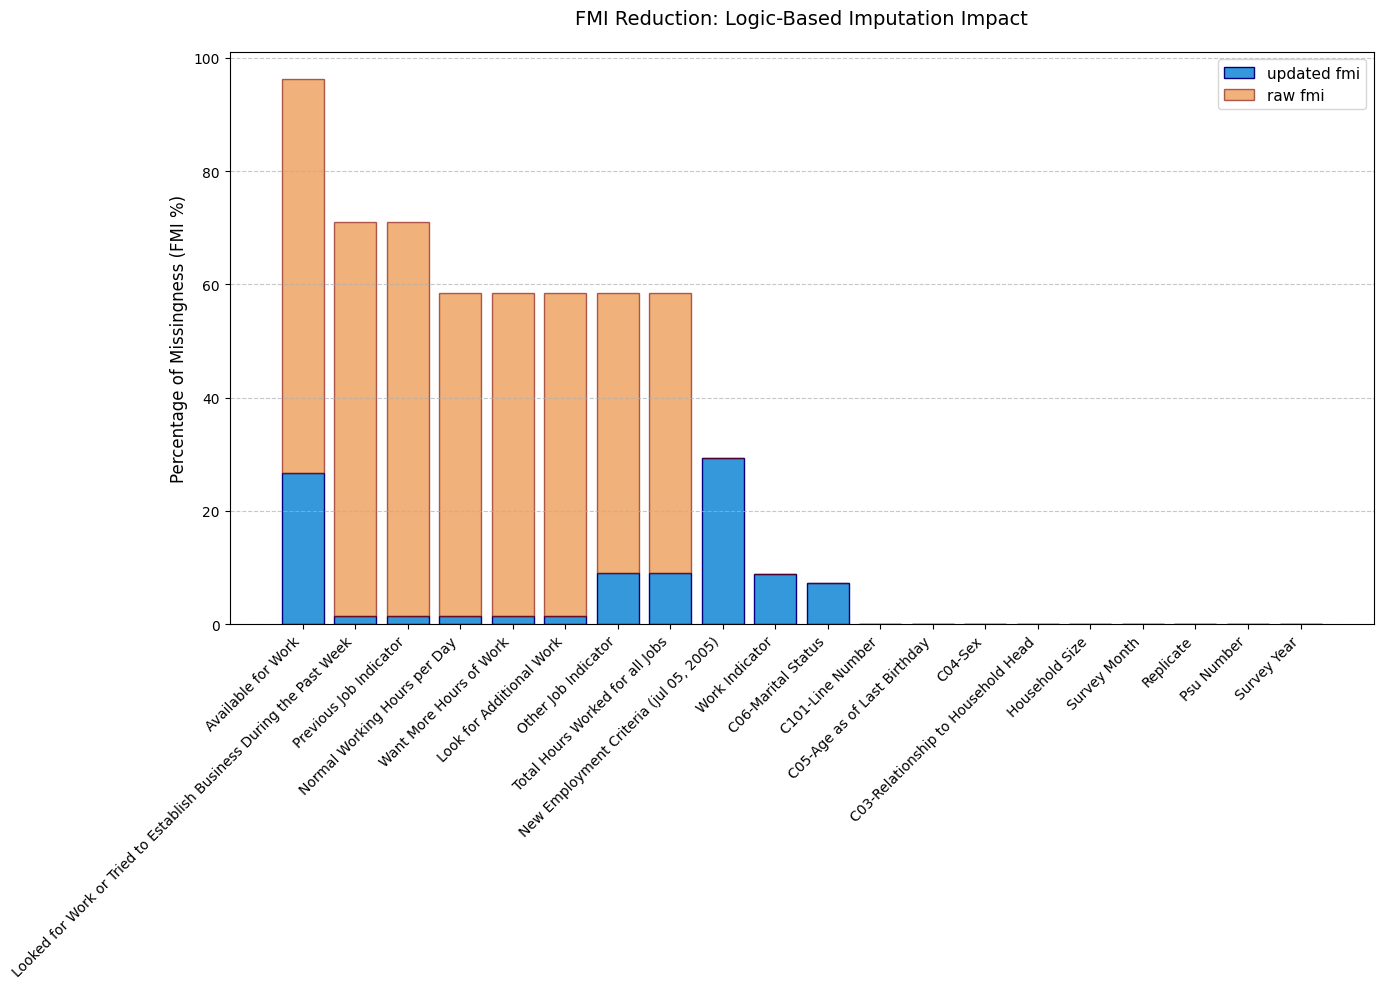

,Variable,raw fmi,updated fmi,reduction
0,Available for Work,96.234241,26.771522,69.462719
1,Looked for Work or Tried to Establish Business...,70.980588,1.517870,69.462719
2,Previous Job Indicator,70.980588,1.517870,69.462719
3,Normal Working Hours per Day,58.442027,1.517870,56.924157
4,Want More Hours of Work,58.442027,1.517870,56.924157
5,Look for Additional Work,58.442027,1.517870,56.924157
6,Other Job Indicator,58.398546,9.124641,49.273905
7,Total Hours Worked for all Jobs,58.398546,9.124641,49.273905
8,"New Employment Criteria (jul 05, 2005)",29.422616,29.422616,0.000000
9,Work Indicator,8.804323,8.804323,0.000000


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- USE YOUR EXISTING PATH DEFINITIONS ---
# BASE_PATH is already defined in your first code block
FMI_OLD_ROOT = BASE_PATH / "NEW FMI Reports"
FMI_NEW_ROOT = BASE_PATH / "NEW FMI Report (Post-Logic-Based Imputation)"
FILE_NAME = "fmi_profile_consistent.csv"

def plot_fmi_comparison_stacked():
    # Construct full paths
    path_old = FMI_OLD_ROOT / FILE_NAME
    path_new = FMI_NEW_ROOT / FILE_NAME
    
    if not path_old.exists() or not path_new.exists():
        print(f"[ERROR] Check paths:\nOld exists: {path_old.exists()} ({path_old})\nNew exists: {path_new.exists()} ({path_new})")
        return

    # 1. Load Data
    df_old = pd.read_csv(path_old)
    df_new = pd.read_csv(path_new)

    # 2. Preparation
    # Multiply by 100 to show as percentages as you did in your first plot
    old_fmi = df_old[["Variable", "OverallFMI"]].rename(columns={"OverallFMI": "raw fmi"})
    old_fmi["raw fmi"] = old_fmi["raw fmi"] * 100
    
    new_fmi = df_new[["Variable", "OverallFMI"]].rename(columns={"OverallFMI": "updated fmi"})
    new_fmi["updated fmi"] = new_fmi["updated fmi"] * 100

    # Merge and Sort
    comparison_df = pd.merge(old_fmi, new_fmi, on="Variable", how="inner")
    comparison_df = comparison_df.sort_values(by="raw fmi", ascending=False)
    
    # Calculate the 'reduction' segment for the stack
    comparison_df['reduction'] = (comparison_df['raw fmi'] - comparison_df['updated fmi']).clip(lower=0)

    # 3. Plotting
    plt.figure(figsize=(14, 10))
    
    # Bottom part of stack (What remains)
    plt.bar(comparison_df['Variable'], comparison_df['updated fmi'], 
            label='updated fmi', color='#3498db', edgecolor='navy')
    
    # Top part of stack (What was recovered/reduced)
    plt.bar(comparison_df['Variable'], comparison_df['reduction'], 
            bottom=comparison_df['updated fmi'], 
            label='raw fmi', color='#e67e22', alpha=0.6, edgecolor='maroon')

    # 4. Styling
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel('Percentage of Missingness (FMI %)', fontsize=12)
    plt.title('FMI Reduction: Logic-Based Imputation Impact', fontsize=14, pad=20)
    
    # Add a horizontal grid for readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Legend - placing it to the right
    plt.legend(frameon=True, fontsize=11)
    
    plt.tight_layout()
    plt.show()

    # Display numeric summary
    display_cols = ['Variable', 'raw fmi', 'updated fmi', 'reduction']
    display(comparison_df[display_cols].reset_index(drop=True))

# Run the plot
plot_fmi_comparison_stacked()